In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import roc_auc_score

In [100]:
import warnings
warnings.filterwarnings('ignore')

In [101]:
#Set two decimal points for display
pd.options.display.float_format = "{:.2f}".format

# Load the Data

In [102]:
import pyreadstat
uds, meta = pyreadstat.read_sas7bdat("C:/Users/tsb7592/Downloads/armada_uds_sep21_di.sas7bdat")
uds.shape

(1046, 652)

In [103]:
marital ={1:"Married", 2:"Widowed", 3:"Divorced",
4:"Separated", 5:"Never married (or marriage was annulled) ",
6:"Living as married/domestic partner", 9:"Other  or  unknown"}

In [104]:
#Rename the value under column cohort2
uds.MARISTAT = uds.MARISTAT.map(marital)

In [105]:
uds.MARISTAT.value_counts()

Married                                      333
Widowed                                      100
Divorced                                      98
Never married (or marriage was annulled)      21
Living as married/domestic partner             6
Separated                                      4
Name: MARISTAT, dtype: int64

In [106]:
um = uds[['ptid','MARISTAT']].drop_duplicates()

In [107]:
armada= pd.read_csv("C:/Users/tsb7592/Downloads/ARMADA_TBSCORES_MAY2020.csv")
armada.shape

(1083, 189)

In [108]:
armada = pd.merge(armada, um, on='ptid', how='left')

In [109]:
armada.shape

(1095, 190)

In [110]:
armada.assmnt.value_counts()

1    823
2    272
Name: assmnt, dtype: int64

In [111]:
armada.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,VisualAc_Raw,VisualAc_svalogmar,VisualAc_svasnellen,VisualAc_UCSScore,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary,MARISTAT
0,1.45635,1,Emory,6,en-US,82,2,1,2,0,...,82.00,-0.04,20/16-3,95.00,20.00,18.00,10.00,11.60,2,Widowed
1,1.46421,1,Emory,4,en-US,88,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Married
2,1.46421,2,Emory,4,en-US,89,1,1,1,1,...,76.00,0.08,20/20-4,82.00,0.00,0.00,26.00,26.00,1,Married
3,1.46422,1,Emory,3,en-US,88,2,1,1,1,...,70.00,0.20,20/30,70.00,7.00,9.00,20.40,18.80,1,Married
4,1.46422,2,Emory,3,en-US,89,2,1,1,1,...,77.00,0.06,20/20-3,84.00,5.00,8.00,22.00,19.60,1,Married


In [112]:
cohort ={1:"Gen population healthy aging 85+", 2:"Gen population 65-85", 3:"Gen population MCI",
4:"Gen population AD", 5:"African American mild cognitive impairment",
6:"African American normal controls 65-85", 7:"Spanish Speaking mild cognitive impairment",
8:"Spanish Speaking normal controls 65-85", 9:"Spanish Speaking AD"}

In [113]:
#Rename the value under column cohort2
armada['cohort2'] = armada['cohort2'].map(cohort)

In [114]:
#recode Male
armada['MALE'] = np.where(armada['gender_rc'] == 1, 1, 0)
armada[['gender_rc','MALE']].head()

,gender_rc,MALE
0,2,0
1,1,1
2,1,1
3,2,0
4,2,0


In [115]:
armada.cohort2.value_counts()

Gen population 65-85                          272
Gen population MCI                            142
Gen population healthy aging 85+              140
African American normal controls 65-85        130
Spanish Speaking normal controls 65-85        130
Spanish Speaking mild cognitive impairment    125
Gen population AD                              85
African American mild cognitive impairment     46
Spanish Speaking AD                            25
Name: cohort2, dtype: int64

In [116]:
#filter by assmnt = 1
armada = armada[armada.assmnt==1]

In [117]:
armada.race_tb_rc.value_counts()

1     429
2     189
32    187
8       5
64      3
0       2
3       2
4       2
11      2
5       1
9       1
Name: race_tb_rc, dtype: int64

In [118]:
race ={1: "White", 2:"Black or African American",4: "Asian",8: "American Indian or Alaska Native",16: "Native Hawaiian or Other Pacific Islanders",32:"Other", 64: "Not Provided"} 

In [119]:
#Rename the value under column race
armada['race'] = armada['race_tb_rc'].map(race)

In [120]:
armada.shape

(823, 192)

A table for demographics. I think you had all of it in your previous thread, except education, which, instead of being averaged numerically, needs to be recoded into separate categories like so:
 

                                      EDUCATION %in% c(1:16) ~ "HSandLess",

                                      EDUCATION %in% c(18:20, 25:27) ~ "Some College",

                                      EDUCATION %in% c(21) ~ "College",

                                      EDUCATION %in% c(22:24) ~ "Graduate",

 

In [121]:
edu_recode={1:"HSandLess", 2:"HSandLess", 3:"HSandLess", 4:"HSandLess", 5:"HSandLess", 6:"HSandLess",
7:"HSandLess", 8:"HSandLess", 9:"HSandLess", 10:"HSandLess", 11:"HSandLess", 12:"HSandLess", 13:"HSandLess",
14:"HSandLess",
16:"HSandLess",
18:"Some College",
20:"Some College",
21:"College",
22:"Graduate",
23:"Graduate",
24:"Graduate",
25:"Some College",
26:"Some College",
27:"Some College",
28:"Some College"}

In [122]:
select = [ 'Gen population 65-85', 'Gen population healthy aging 85+']
genpop = armada[armada.cohort2.isin(select)]

In [123]:
#Recode Edu to norming value
genpop['EDUCATION_CATE'] = genpop['EDUCATION'].map(edu_recode)

In [124]:
edu={1:0, 2:0, 3:0, 4:1, 5:2, 6:3,
7:4, 8:5, 9:6, 10:7, 11:8, 12:9, 13:10,
14:11,
16:12,
18:12,
20:14,
21:16,
22:18,
23:20,
24:20,
25:13,
26:13,
27:14,
28:15}

In [125]:
genpop['EDUCATION_CATE'].value_counts(normalize=True)

Graduate       0.52
College        0.29
Some College   0.11
HSandLess      0.07
Name: EDUCATION_CATE, dtype: float64

In [126]:
genpop.cohort2.value_counts()

Gen population 65-85                164
Gen population healthy aging 85+    116
Name: cohort2, dtype: int64

In [127]:
def add_percentage(df, val):
    ee =df.groupby(val)['cohort2'].value_counts().unstack().fillna(0)
    ee['65-85 Percentage']=ee['Gen population 65-85']/ee['Gen population 65-85'].sum()
    ee['85+ Percentage']=ee['Gen population healthy aging 85+']/ee['Gen population healthy aging 85+'].sum()
    
    return ee.round(2)

In [128]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('C:/Users/tsb7592/Downloads/demo_table.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
add_percentage(genpop, 'race').to_excel(writer, sheet_name='race')
add_percentage(genpop, 'MALE').to_excel(writer, sheet_name='male')
add_percentage(genpop, 'EDUCATION_CATE').to_excel(writer, sheet_name='edu')
add_percentage(genpop, 'MARISTAT').to_excel(writer, sheet_name='maristat')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [129]:
ee=add_percentage(genpop, 'MALE')
ee

cohort2,Gen population 65-85,Gen population healthy aging 85+,65-85 Percentage,85+ Percentage
MALE,,,,
0,111,59,0.68,0.51
1,53,57,0.32,0.49


In [130]:
ee['Gen population 65-85'].to_numpy()[0]

111

In [131]:
ee['Gen population healthy aging 85+'].to_numpy()[0]

59

In [132]:
ee

cohort2,Gen population 65-85,Gen population healthy aging 85+,65-85 Percentage,85+ Percentage
MALE,,,,
0,111,59,0.68,0.51
1,53,57,0.32,0.49


In [133]:
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def chi2_test(obs, exp):
    l1 =exp.to_numpy()
    l2= obs.to_numpy()
    for i in range(len(obs)):
        data = [l1[i], l2[i]]
        display(data)
        stat, p, dof, expected = chi2_contingency(data)

        # interpret test-statistic
        prob = 0.95
        critical = chi2.ppf(prob, dof)
        print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
        if abs(stat) >= critical:
            print('Dependent (reject H0)')
        else:
            print('Independent (fail to reject H0)')

       # interpret p-value
        alpha = 1.0 - prob
        print('significance=%.3f, p=%.3f' % (alpha, p))
        if p <= alpha:
            print('Dependent (reject H0)')
        else:
            print('Independent (fail to reject H0)')
        print('')
   

    return 

In [134]:
chi2_test(ee['65-85 Percentage'], ee['85+ Percentage'])

[0.51, 0.68]

probability=0.950, critical=nan, stat=0.000
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)



[0.49, 0.32]

probability=0.950, critical=nan, stat=0.000
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)



In [135]:
#Recode Edu to norming value
genpop['EDUCATION'] = genpop['EDUCATION'].map(edu)

In [136]:
armada[['CTC_ACSScore','CCC_ACSScore', 'CFC_ACSScore']].describe()

,CTC_ACSScore,CCC_ACSScore,CFC_ACSScore
count,589.00,688.00,590.00
mean,101.26,109.07,93.42
std,14.98,14.61,16.53
min,60.00,68.00,43.00
25%,91.00,100.00,81.00
50%,102.00,110.00,93.00
75%,112.00,120.00,105.00
max,139.00,146.00,144.00


# 85 Norm

In [137]:
genpop['race_tb_rc'].value_counts()

1     239
2      35
8       2
4       1
9       1
32      1
64      1
Name: race_tb_rc, dtype: int64

In [138]:
genpop['single'] =genpop[['racetb_w','racetb_b','racetb_as','racetb_ai','racetb_nhpi','racetb_oth','racetb_no']].sum(axis=1)

In [139]:
#There are only 1 participant has reported to have more than one race 
genpop[genpop['single']==2][['racetb_w','racetb_b','racetb_as','racetb_ai','racetb_nhpi','racetb_oth','racetb_no']]

,racetb_w,racetb_b,racetb_as,racetb_ai,racetb_nhpi,racetb_oth,racetb_no
453,1,0,0,1,0,0,0


In [140]:
genpop['single'].value_counts()

1    279
2      1
Name: single, dtype: int64

# Raw to Scaled Score (ss) for use in Fully-corrected Formulas

## Hispanic Adults (18-85 years old) page6

If they choose Hispanic and any other single race (other than Black/African-American), use Hispanic
If they choose Hispanic and two or more races (including “other” e.g. White+Other), Multi-racial for kids or Black/African-American for adults


In [141]:
genpop.columns

Index(['ptid', 'assmnt', 'site', 'cohort2', 'LANGUAGE', 'AGE', 'gender_rc',
       'ethnicity_rc', 'race_tb_rc', 'racetb_w',
       ...
       'WIN_Raw_L', 'WIN_Raw_R', 'WIN_Thresh_L', 'WIN_Thresh_R',
       'race_summary', 'MARISTAT', 'MALE', 'race', 'EDUCATION_CATE', 'single'],
      dtype='object', length=194)

In [142]:
#all hispanic only choose single race
genpop[(genpop['ethnicity_rc']==2)][['racetb_w','racetb_b','racetb_as','racetb_ai','racetb_nhpi','racetb_oth','racetb_no']]

,racetb_w,racetb_b,racetb_as,racetb_ai,racetb_nhpi,racetb_oth,racetb_no
192,1,0,0,0,0,0,0
221,0,0,0,0,0,1,0
326,1,0,0,0,0,0,0
528,1,0,0,0,0,0,0
641,0,1,0,0,0,0,0
661,0,1,0,0,0,0,0


In [143]:
#If they ever indicate “Black/African-American” use Black/African-American norms
hp =genpop[(genpop['ethnicity_rc']==2) &(genpop['racetb_b']!=1)]
hp

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary,MARISTAT,MALE,race,EDUCATION_CATE,single
192,2805,1,UCSD,Gen population healthy aging 85+,en-US,87,2,2,1,1,...,0.00,0.00,26.00,26.00,9,Widowed,0,White,Some College,1
221,3487,1,UCSD,Gen population 65-85,en-US,84,2,2,32,0,...,5.00,6.00,22.00,21.20,9,Living as married/domestic partner,0,Other,Graduate,1
326,8150,1,UCSD,Gen population healthy aging 85+,en-US,85,1,2,1,1,...,0.00,1.00,26.00,25.20,9,Widowed,1,White,Graduate,1
528,ADRC00745,1,UWisc,Gen population 65-85,en-US,75,1,2,1,1,...,19.00,20.00,10.80,10.00,9,Married,1,White,College,1


In [144]:
aalabel =[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [145]:
label2 =[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [146]:
#Raw_to_ScaledScore
cut_bins = [0, 0.87, 2.15, 2.28, 4.73, 6.7, 7.43, 7.74, 8.05, 8.32, 8.67, 8.86, 9.27, 9.46, 9.66, 9.89, 100]
hp['DCCS_fss'] = pd.cut(hp['DCCS_CScore'], bins=cut_bins, labels=label2)

cut_bins = [0, 3.44, 5.69, 6.75, 7.64, 8.04, 8.24, 8.33, 8.74, 8.98, 9.16, 9.37, 9.48, 9.64, 9.76, 9.99, 100]
hp['Flanker_fss'] = pd.cut(hp['Flanker_CScore'], bins=cut_bins, labels=label2)

cut_bins = [0, 4, 7, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26]
hp['LSWM_fss'] = pd.cut(hp['LSWM_Raw'], bins=cut_bins, labels=aalabel)

In [147]:
cut_bins = [200, 235.69, 310.53, 339.79, 355.26, 403.52, 428.28, 474.55, 520.25, 571.80, 594.02, 626.25, 651.07, 677.55, 683.45, 698.33, 749.31, 800]
hp['PSM_fss'] = pd.cut(hp['PSM_CScore'], bins=cut_bins, labels=aalabel)

In [148]:
cut_bins = [0, 16, 32, 39, 44, 47, 49, 52, 57, 60, 63, 65, 69, 72, 74, 80, 102, 130]
hp['PCPS_fss'] = pd.cut(hp['PCPS_CScore'], bins=cut_bins, labels=aalabel)

In [149]:
cut_bins = [-30, -12.15, -2.01, -1.15, 0.26, 0.86, 2.21, 2.82, 3.88, 5.08, 6.22, 7.02, 7.57, 8, 8.86, 9.03, 12.91, 20]
hp['ORR_fss'] = pd.cut(hp['ORR_Theta'], bins=cut_bins, labels=aalabel)

In [150]:
cut_bins = [-15, -8.5, -1.76, 0.07, 1.29, 1.93, 2.6, 3.27, 3.68, 4.56, 5.63, 6.24, 7.33, 7.91, 8.64, 9.23, 12.38, 15]
hp['TPVT_fss'] = pd.cut(hp['TPVT_Theta'], bins=cut_bins, labels=aalabel)

# Raw to Scaled Score (ss) for use in Fully-corrected Formulas

##  White/Asian Adults (18-85 years old) page4

If they choose only White or only Asian, and not Hispanic, use White/Asian


In [151]:
genpop[(genpop['racetb_w']==1)]


,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary,MARISTAT,MALE,race,EDUCATION_CATE,single
25,1.64163,1,Emory,Gen population healthy aging 85+,en-US,86,1,1,1,1,...,7.00,15.00,20.40,14.00,1,Married,1,White,Graduate,1
39,1.70940,1,Emory,Gen population healthy aging 85+,en-US,86,1,1,1,1,...,16.00,18.00,13.20,11.60,1,Married,1,White,College,1
72,1148,1,NU,Gen population 65-85,en-US,82,2,1,1,1,...,17.00,13.00,12.40,15.60,1,Married,0,White,Graduate,1
74,1149,1,NU,Gen population 65-85,en-US,84,1,1,1,1,...,16.00,22.00,13.20,8.40,1,Married,1,White,College,1
76,1152,1,NU,Gen population 65-85,en-US,73,2,1,1,1,...,16.00,13.00,13.20,15.60,1,Married,0,White,Graduate,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,UM00001612,1,UMich,Gen population 65-85,en-US,69,2,1,1,1,...,23.00,22.00,7.60,8.40,1,Married,0,White,Graduate,1
825,UM00001616,1,UMich,Gen population 65-85,en-US,71,1,1,1,1,...,8.00,16.00,19.60,13.20,1,Married,1,White,Graduate,1
829,UM00001652,1,UMich,Gen population 65-85,en-US,76,2,1,1,1,...,16.00,14.00,13.20,14.80,1,Married,0,White,Graduate,1
834,UM00001679,1,UMich,Gen population 65-85,en-US,83,2,1,1,1,...,16.00,14.00,13.20,14.80,1,Never married (or marriage was annulled),0,White,Graduate,1


In [156]:
wt= genpop[((genpop['racetb_as']==1)|(genpop['racetb_w']==1))&(genpop['single']==1)]
wt.shape

(240, 194)

In [158]:
#Raw_to_ScaledScore
cut_bins = [0, 0.54, 2.06, 2.2, 2.91, 3.81, 5.82, 6.6, 7.1, 7.53, 7.88, 8.15, 8.5, 8.77, 9.03, 9.3, 9.69, 9.87, 9.99, 100]
wt['DCCS_fss'] = pd.cut(wt['DCCS_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 0.68, 4.06, 4.36, 4.95, 6.17, 6.75, 7.42, 7.83, 8.16, 8.45, 8.73, 8.95, 9.18, 9.4, 9.58, 9.73, 9.87,9.99,100]
wt['Flanker_fss'] = pd.cut(wt['Flanker_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 1, 3, 5, 7, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26]
wt['LSWM_fss'] = pd.cut(wt['LSWM_Raw'], bins=cut_bins, labels=list(range(19)))

In [159]:
cut_bins = [200, 203.32, 244.53, 289.78, 300.46, 331.71, 352.26, 382.36, 417.12, 442.95, 480.65, 522.65, 550.57, 596.9, 624.29, 653.19, 677.92, 690.73, 700.91, 722.91, 794.52, 800.00]
wt['PSM_fss'] = pd.cut(wt['PSM_CScore'], bins=cut_bins, labels=list(range(21)))

In [160]:
cut_bins = [0,5,25,27,28,32,38,42,46,49,53,56,60,65,68,72,75,78,81,87,124,130]
wt['PCPS_fss'] = pd.cut(wt['PCPS_CScore'], bins=cut_bins, labels=list(range(21)))

In [161]:
cut_bins = [-30, -24.08, -5.18, -3.43, -1.06, -0.13, 0.7, 1.58, 2.58, 3.39, 4.27, 5.12, 6.03, 6.91, 7.71, 8.38, 8.94, 9.21, 9.63, 11.04, 18.78, 20.00]
wt['ORR_fss'] = pd.cut(wt['ORR_Theta'], bins=cut_bins, labels=list(range(21)))

In [162]:
cut_bins = [-15, -14.66, -4.72, -3.2, -1.15, 0.53, 1.87, 2.77, 3.61, 4.16, 4.73, 5.26, 5.9, 6.6, 7.37, 8.09, 8.88, 9.62, 10.37, 10.75, 14.85, 15]
wt['TPVT_fss'] = pd.cut(wt['TPVT_Theta'], bins=cut_bins, labels=list(range(21)))

# Raw to Scaled Score (ss) for use in Fully-corrected Formulas

##  African American Adults (18-85 years old) page5
If they ever indicate “Black/African-American” use Black/African-American norms
If they choose any other single race and not Hispanic (including NHOPI, Native American, Other [only]) use Black/African-American norms
If they choose two or more races, use multi-racial for kids or Black/African-American norms for adults

In [181]:
aa= genpop[(genpop['racetb_b']==1)|(genpop['single']!=1)]
aa

,index,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,...,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary,MARISTAT,MALE,race,EDUCATION_CATE,single
0,13,1.50313,1,Emory,Gen population 65-85,en-US,68,2,1,2,...,16.00,16.00,13.20,13.20,2,Divorced,0,Black or African American,College,1
1,17,1.52966,1,Emory,Gen population 65-85,en-US,74,1,1,2,...,22.00,22.00,8.40,8.40,2,Married,1,Black or African American,College,1
2,19,1.53368,1,Emory,Gen population healthy aging 85+,en-US,91,2,1,2,...,1.00,0.00,25.20,26.00,2,Widowed,0,Black or African American,Graduate,1
4,37,1.70772,1,Emory,Gen population healthy aging 85+,en-US,87,1,1,2,...,18.00,14.00,11.60,14.80,2,Widowed,1,Black or African American,Graduate,1
6,54,101149735,1,Mayo,Gen population healthy aging 85+,en-US,89,2,1,2,...,9.00,7.00,18.80,20.40,2,Widowed,0,Black or African American,Some College,1
7,64,101151423,1,Mayo,Gen population 65-85,en-US,71,2,1,2,...,22.00,18.00,8.40,11.60,2,Divorced,0,Black or African American,HSandLess,1
8,65,101151431,1,Mayo,Gen population 65-85,en-US,66,1,1,2,...,21.00,23.00,9.20,7.60,2,Married,1,Black or African American,College,1
9,67,101151479,1,Mayo,Gen population 65-85,en-US,80,1,1,2,...,22.00,18.00,8.40,11.60,2,Married,1,Black or African American,College,1
14,80,15784393,1,Mayo,Gen population 65-85,en-US,82,1,1,2,...,6.00,9.00,21.20,18.80,2,Married,1,Black or African American,Graduate,1
15,81,15827182,1,Mayo,Gen population 65-85,en-US,83,1,1,2,...,13.00,16.00,15.60,13.20,2,Divorced,1,Black or African American,Some College,1


In [182]:
wt.shape[0]+aa.shape[0]+hp.shape[0]

280

In [183]:
LSlabel =[2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18]

In [184]:
#Raw_to_ScaledScore
cut_bins = [0, 2.14, 2.51, 5.1, 6.6, 7.07, 7.36, 7.63, 7.91, 8.17, 8.39, 8.56, 8.8, 9.24, 9.52, 9.73, 9.85, 100]
aa['DCCS_fss'] = pd.cut(aa['DCCS_CScore'], bins=cut_bins, labels=aalabel)

cut_bins = [0, 4.59, 5.47, 6.01, 6.73, 7.36, 7.85, 8.07, 8.31, 8.53, 8.77, 8.98, 9.3, 9.44, 9.65, 9.77, 9.98, 100]
aa['Flanker_fss'] = pd.cut(aa['Flanker_CScore'], bins=cut_bins, labels=aalabel)

cut_bins = [0, 6, 8, 10, 11, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 26]
aa['LSWM_fss'] = pd.cut(aa['LSWM_Raw'], bins=cut_bins, labels=LSlabel)

In [185]:
cut_bins = [200, 311.14, 324.52, 333.35, 359.23, 376.23, 400.45, 428.47, 469.41, 500.82, 528.54, 585.59, 614.46, 639.02, 667.76, 689.98, 705.78, 800.00]
aa['PSM_fss'] = pd.cut(aa['PSM_CScore'], bins=cut_bins, labels=aalabel)

In [186]:
cut_bins = [0, 24, 30, 33, 37, 40, 43, 47, 52, 55, 58, 61, 65, 69, 73, 76, 83, 130]
aa['PCPS_fss'] = pd.cut(aa['PCPS_CScore'], bins=cut_bins, labels=aalabel)

In [187]:
cut_bins = [-30, -10.91, -3.66, -1.97, -1.32, -0.57, 0.83, 1.87, 2.74, 3.52, 4.17, 5.04, 5.84, 7.39, 8.36, 8.78, 8.97, 20]
aa['ORR_fss'] = pd.cut(aa['ORR_Theta'], bins=cut_bins, labels=aalabel)

In [188]:
cut_bins = [-15, -2.24, -0.45, 0.36, 0.74, 1.39, 2.06, 2.77, 3.54, 3.89, 4.4, 5.08, 5.33,  5.94, 7.67, 9.16, 9.43, 15]
aa['TPVT_fss'] = pd.cut(aa['TPVT_Theta'], bins=cut_bins, labels=aalabel)

In [189]:
int_df = pd.merge(aa, hp, how ='inner', on =['ptid'])
display(int_df)

,index,ptid,assmnt_x,site_x,cohort2_x,LANGUAGE_x,AGE_x,gender_rc_x,ethnicity_rc_x,race_tb_rc_x,...,race_y,EDUCATION_CATE_y,single_y,DCCS_fss_y,Flanker_fss_y,LSWM_fss_y,PSM_fss_y,PCPS_fss_y,ORR_fss_y,TPVT_fss_y


# Hispanic-Appendix 2.3 Scaled Scores to Fully-corrected scores 

In [190]:
#DCCS  +
def DFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss-(9.17-10.11*(age/100) + 3.51*(edu/10) + 0.18*male))/ (2.18- 0.36*(age/100) - 0.11*(edu/10) + 0.06*male))) / 1.29
    return rv

In [191]:
hp['DCCS_FC'] = hp.apply(lambda x: DFully_correct(x.DCCS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [192]:
hp['DCCS_FC']=hp['DCCS_FC'].clip(19,81)

In [193]:
hp['DCCS_FDiff']=hp['DCCS_FCTScore']-hp['DCCS_FC']

In [194]:
hp[hp.DCCS_FDiff>1][['ptid','site','AGE','DCCS_FC','DCCS_FCTScore','DCCS_FDiff']]

,ptid,site,AGE,DCCS_FC,DCCS_FCTScore,DCCS_FDiff


In [195]:
#Flanker
def FFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) - (11.56 - 10.32*(age/100) + 1.68*(edu/10) + 0.99*male)) / (2.07 - 1.00*(age/100) + 0.29*(edu/10) -0.46*male)) / 1.30
    return rv

In [196]:
hp['Flanker_FC'] = hp.apply(lambda x: FFully_correct(x.Flanker_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [197]:
hp['Flanker_FC']=hp['Flanker_FC'].clip(19,81)

In [198]:
hp['Flanker_FDiff']=hp['Flanker_FCTScore']-hp['Flanker_FC']

In [199]:
hp[hp.Flanker_FDiff>1][['ptid','site','AGE','Flanker_FC','Flanker_FCTScore','Flanker_FDiff']]

,ptid,site,AGE,Flanker_FC,Flanker_FCTScore,Flanker_FDiff


In [200]:
#List Sort
def LFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) - (11.27- 9.35*(age/100) + 1.27*(edu/10) + 1.53*male)) / (2.69 -0.54*(age/100) - 0.30*(edu/10) + 0.30*male))/ 1.20
    return rv

In [201]:
hp['LSWM_FC'] = hp.apply(lambda x: LFully_correct(x.LSWM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [202]:
hp['LSWM_FC']=hp['LSWM_FC'].clip(19,81)

In [203]:
hp['LSWM_FDiff']=hp['LSWM_FCTScore']-hp['LSWM_FC']

In [204]:
hp[hp.LSWM_FDiff>1][['ptid','site','AGE','LSWM_FC','LSWM_FCTScore','LSWM_FDiff']]

,ptid,site,AGE,LSWM_FC,LSWM_FCTScore,LSWM_FDiff


In [205]:
#Picture sequence memory
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(11.19 -8.84*(age/100) + 1.63*(edu/10) + 0.39*male)) / (1.07 + 0.09*(age/100) + 0.58*(edu/10) + 0.44*male)) / 1.27
    
    return rv

In [206]:
hp['PSM_FC'] = hp.apply(lambda x: PFully_correct(x.PSM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [207]:
hp['PSM_FC']=hp['PSM_FC'].clip(19,81)

In [208]:
hp['PSM_FDiff']=hp['PSM_FCTScore']-hp['PSM_FC']

In [209]:
hp[hp.PSM_FDiff>1][['ptid','site','AGE','PSM_FC','PSM_FCTScore','PSM_FDiff']]

,ptid,site,AGE,PSM_FC,PSM_FCTScore,PSM_FDiff


In [210]:
#Pattern comparison
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.15- (11.01*age/100) + (1.71*edu/10) -0.13*male)) / (1.83 - (0.63*age/100) +( 0.34*edu/10) + 0.02*male)) / 1.21
    return rv

In [211]:
hp['PCPS_FC'] = hp.apply(lambda x: PFully_correct(x.PCPS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [212]:
hp['PCPS_FC']=hp['PCPS_FC'].clip(19,81)

In [213]:
hp['PCPS_FDiff']=hp['PCPS_FCTScore']-hp['PCPS_FC']

In [214]:
hp[hp.PCPS_FDiff>1][['ptid','site','AGE','PCPS_FC','PCPS_FCTScore','PCPS_FDiff']]

,ptid,site,AGE,PCPS_FC,PCPS_FCTScore,PCPS_FDiff


In [215]:
#Oral Reading
def OFully_correct(ss, age, edu, male):
    rv = 50 + 10 * (((ss) -(1.37 + (0.51*age/100) + (5.84*edu/10) + 0.40*male)) / (1.66+ (2.08*age/100)- (0.33*edu/10) + 0.07*male)) / 1.22
    return rv

In [216]:
hp['ORR_FC'] = hp.apply(lambda x: OFully_correct(x.ORR_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [217]:
hp['ORR_FC']=hp['ORR_FC'].clip(19,81)

In [218]:
hp['ORR_FDiff']=hp['ORR_FCTScore']-hp['ORR_FC']

In [219]:
#Pattern comparison
def PCFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(0.74 + 5.17*(age/100) + 4.91*(edu/10) + 0.74*male)) / (1.74 + 1.16*(age/100) - 0.15*(edu/10) + 0.07*male)) / 1.23
    return rv

In [220]:
hp['TPVT_FC'] = hp.apply(lambda x: PCFully_correct(x.TPVT_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [221]:
hp['TPVT_FC']=hp['TPVT_FC'].clip(19,81)

In [222]:
hp['TPVT_FDiff']=hp['TPVT_FCTScore']-hp['TPVT_FC']

In [223]:
#Fluid Composite
#50 + 10 * (((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Fully-corrected T-Scores) – 50.28) / 6.99) 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 50 + 10 *(avg- 50.28) / 6.99
    return rv

In [224]:
hp['CFC_FC'] = hp.apply(lambda x: Fluid_composite(x.DCCS_FC, x.Flanker_FC, x.LSWM_FC, x.PSM_FC, x.PCPS_FC), axis=1)

In [225]:
hp['CFC_FDiff']=hp['CFC_FCTScore']-hp['CFC_FC']

In [226]:
hp[['CFC_FCTScore','CFC_FC','CFC_FDiff']]

,CFC_FCTScore,CFC_FC,CFC_FDiff
192,NaN,74.86,NaN
221,42.00,41.73,0.27
326,43.00,43.25,-0.25
528,50.00,50.21,-0.21


In [227]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary fully-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-50.11) / 8.89
    return rv

In [228]:
hp['CCC_FC'] = hp.apply(lambda x: Crystallized_composite(x.ORR_FC, x.TPVT_FC), axis=1)

In [229]:
hp['CCC_FDiff']=hp['CCC_FCTScore']-hp['CCC_FC']

In [230]:
hp[['CCC_FCTScore','CCC_FC','CCC_FDiff']]

,CCC_FCTScore,CCC_FC,CCC_FDiff
192,NaN,65.92,NaN
221,63.00,63.32,-0.32
326,46.00,46.09,-0.09
528,57.00,57.20,-0.20


In [231]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-49.83) / 8.46
    return rv

In [232]:
hp['CTC_FC'] = hp.apply(lambda x: Crystallized_composite(x.CCC_FC, x.CFC_FC), axis=1)

In [233]:
hp['CTC_FDiff']=hp['CTC_FCTScore']-hp['CTC_FC']

# African -Appendix 2.3 Scaled Scores to Fully-corrected scores 

In [234]:
#DCCS  +
def DFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(11.82 - 11.22*(age/100) + 2.13*(edu/10) + 0.32*male)) / (3.04 - 1.17*(age/100) -0.44*(edu/10) + 0.10*male)) / 1.26
    return rv

In [235]:
aa['DCCS_FC'] = aa.apply(lambda x: DFully_correct(x.DCCS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [236]:
aa['DCCS_FC']=aa['DCCS_FC'].clip(19,81)

In [237]:
aa['DCCS_FDiff']=aa['DCCS_FCTScore']-aa['DCCS_FC']

In [238]:
#Flanker
def FFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(11.77 -7.52*(age/100) + 1.07*(edu/10) + 0.002*male)) / (1.76 + 0.18*(age/100) + 0.22*(edu/10) + 0.37*male)) / 1.24
    return rv

In [239]:
aa['Flanker_FC'] = aa.apply(lambda x: FFully_correct(x.Flanker_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [240]:
aa['Flanker_FC']=aa['Flanker_FC'].clip(19,81)

In [241]:
aa['Flanker_FDiff']=aa['Flanker_FCTScore']-aa['Flanker_FC']

In [242]:
#List Sort
def LFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.42 -7.41*(age/100) + 0.57*(edu/10) + 0.58*male)) / (2.14 + 0.43*(age/100) - 0.15*(edu/10) + 0.06*male)) / 1.30
    return rv

In [243]:
aa['LSWM_FC'] = aa.apply(lambda x: LFully_correct(x.LSWM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [244]:
aa['LSWM_FC']=aa['LSWM_FC'].clip(19,81)

In [245]:
aa['LSWM_FDiff']=aa['LSWM_FCTScore']-aa['LSWM_FC']

In [246]:
#Picture sequence memory
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(13.73 -5.86*(age/100) - 0.67*(edu/10) - 1.15*male)) / (3.53 - 1.44*(age/100) - 0.60*(edu/10) + 0.72*male)) / 1.25
    
    return rv

In [247]:
aa['PSM_FC'] = aa.apply(lambda x: PFully_correct(x.PSM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [248]:
aa['PSM_FC']=aa['PSM_FC'].clip(19,81)

In [249]:
aa['PSM_FDiff']=aa['PSM_FCTScore']-aa['PSM_FC']

In [250]:
aa[aa.PSM_FDiff>1][['ptid','site','AGE','PSM_FC','PSM_FCTScore','PSM_FDiff']]

,ptid,site,AGE,PSM_FC,PSM_FCTScore,PSM_FDiff
100,783,UPitt,71,22.98,24.00,1.02
147,ADRC00081,UWisc,70,66.11,69.00,2.89
246,UM00001250,UMich,70,31.79,43.00,11.21


In [251]:
#Pattern comparison
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(15.27 -10.82*(age/100) -0.51*(edu/10) + 0.66*male)) / (2.50- 0.72*(age/100)- 0.24*(edu/10) + 0.58*male)) / 1.24
    return rv

In [252]:
aa['PCPS_FC'] = aa.apply(lambda x: PFully_correct(x.PCPS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [253]:
aa['PCPS_FC']=aa['PCPS_FC'].clip(19,81)

In [254]:
aa['PCPS_FDiff']=aa['PCPS_FCTScore']-aa['PCPS_FC']

In [255]:
aa[aa.PCPS_FDiff>1][['ptid','site','AGE','PCPS_FC','PCPS_FCTScore','PCPS_FDiff']]

,ptid,site,AGE,PCPS_FC,PCPS_FCTScore,PCPS_FDiff
246,UM00001250,UMich,70,30.59,35.00,4.41


In [256]:
#Oral Reading
def OFully_correct(ss, age, edu, male):
    rv = 50 + 10 * (((ss) -(6.05 -1.40*(age/100) + 3.23*(edu/10) + 0.17*male)) / (1.95 + 1.09*(age/100)-0.16*(edu/10) + 0.45*male)) / 1.26
    return rv

In [257]:
aa['ORR_FC'] =aa.apply(lambda x: OFully_correct(x.ORR_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [258]:
aa['ORR_FC']=aa['ORR_FC'].clip(19,81)

In [259]:
aa['ORR_FDiff']=aa['ORR_FCTScore']-aa['ORR_FC']

In [260]:
#Picture Vocabulary
def PVFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(0.56 + 3.11*(age/100) + 5.81*(edu/10) - 0.39*male)) / (2.03 -0.45*(age/100) + 0.14*(edu/10) + 0.20*male)) / 1.27
    return rv

In [261]:
aa['TPVT_FC'] = aa.apply(lambda x: PVFully_correct(x.TPVT_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [262]:
aa['TPVT_FC']=aa['TPVT_FC'].clip(19,81)

In [263]:
aa['TPVT_FDiff']=aa['TPVT_FCTScore']-aa['TPVT_FC']

In [264]:
#Fluid Composite
#50 + 10 * (((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Fully-corrected T-Scores) – 50.28) / 6.99) 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 50 + 10 *(avg- 50.05) / 6.48
    return rv

In [265]:
aa['CFC_FC'] =aa.apply(lambda x: Fluid_composite(x.DCCS_FC, x.Flanker_FC, x.LSWM_FC, x.PSM_FC, x.PCPS_FC), axis=1)

In [266]:
aa['CFC_FDiff']=aa['CFC_FCTScore']-aa['CFC_FC']

In [267]:
aa[['CFC_FCTScore','CFC_FC','CFC_FDiff']]

,CFC_FCTScore,CFC_FC,CFC_FDiff
0,49.00,48.97,0.03
1,44.00,43.58,0.42
2,NaN,59.84,NaN
4,NaN,50.82,NaN
6,NaN,49.81,NaN
7,61.00,61.07,-0.07
8,46.00,46.08,-0.08
9,53.00,52.92,0.08
14,53.00,52.75,0.25
15,32.00,32.03,-0.03


In [268]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-50) / 9.19
    return rv

In [269]:
aa['CCC_FC'] = aa.apply(lambda x: Crystallized_composite(x.ORR_FC, x.TPVT_FC), axis=1)

In [270]:
aa['CCC_FDiff']=aa['CCC_FCTScore']-aa['CCC_FC']

In [271]:
aa[['CCC_FCTScore','CCC_FC','CCC_FDiff']]

,CCC_FCTScore,CCC_FC,CCC_FDiff
0,54.00,53.56,0.44
1,66.00,65.91,0.09
2,NaN,59.81,NaN
4,NaN,51.76,NaN
6,NaN,53.51,NaN
7,51.00,50.71,0.29
8,62.00,62.25,-0.25
9,50.00,49.71,0.29
14,58.00,58.17,-0.17
15,59.00,59.07,-0.07


In [272]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 10+ 10*(avg-50.02) / 8.68
    return rv

In [273]:
aa['CTC_FC'] = aa.apply(lambda x: Crystallized_composite(x.CCC_FC, x.CFC_FC), axis=1)

In [274]:
aa['CTC_FDiff']=aa['CTC_FCTScore']-aa['CTC_FC']

# white-Appendix 2.3 Scaled Scores to Fully-corrected scores 

In [275]:
#DCCS  +
def DFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.92 -9.84*(age/100) + 1.45*(edu/10) + 0.30*male)) / (1.78 - 0.63*(age/100) + 0.16*(edu/10) + 0.32*male)) / 1.28
    return rv

In [276]:
wt['DCCS_FC'] = wt.apply(lambda x: DFully_correct(x.DCCS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [277]:
wt['DCCS_FC']=wt['DCCS_FC'].clip(19,81)

In [278]:
wt['DCCS_FDiff']=wt['DCCS_FCTScore']-wt['DCCS_FC']

In [279]:
wt['DCCS_FC']

25    51.42
39    71.20
72    62.78
74    61.66
76    53.17
       ... 
824   51.24
825   58.68
829   64.49
834   46.77
836   54.16
Name: DCCS_FC, Length: 240, dtype: float64

In [280]:
#Flanker
def FFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss)  -(15.52 -9.25*(age/100) -1.53*(edu/10)**(-2) + 0.29*male)) / (2.23 -0.72*(age/100) - 0.10*(edu/10) + 0.33*male)) / 1.30
    return rv

In [281]:
wt['Flanker_FC'] = wt.apply(lambda x: FFully_correct(x.Flanker_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [282]:
wt['Flanker_FC']=wt['Flanker_FC'].clip(19,81)

In [283]:
wt['Flanker_FDiff']=wt['Flanker_FCTScore']-wt['Flanker_FC']

In [284]:
wt[['Flanker_FDiff','Flanker_FCTScore','Flanker_FC']]

,Flanker_FDiff,Flanker_FCTScore,Flanker_FC
25,NaN,NaN,39.07
39,NaN,NaN,53.21
72,0.17,53.00,52.83
74,-0.39,52.00,52.39
76,-0.42,38.00,38.42
...,...,...,...
824,0.29,47.00,46.71
825,0.05,51.00,50.95
829,0.21,45.00,44.79
834,0.47,48.00,47.53


In [285]:
#List Sort
def LFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.89 -8.36*(age/100) + 1.12*(edu/10) -0.25*male)) / (1.80 + 0.06*(age/100) + 0.25*(edu/10) - 0.04*male)) / 1.22
    return rv

In [286]:
wt['LSWM_FC'] = wt.apply(lambda x: LFully_correct(x.LSWM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [287]:
wt['LSWM_FC']=wt['LSWM_FC'].clip(19,81)

In [288]:
wt['LSWM_FDiff']=wt['LSWM_FCTScore']-wt['LSWM_FC']

In [289]:
wt['LSWM_FC']

25    54.64
39    63.93
72    46.25
74    52.19
76    57.85
       ... 
824   38.78
825   47.38
829   48.03
834   38.87
836   51.30
Name: LSWM_FC, Length: 240, dtype: float64

In [290]:
#Picture sequence memory
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.72 -8.91*(age/100) + 1.51*(edu/10) - 0.97*male)) / (2.42 - 0.49*(age/100)- 0.17*(edu/10) -0.05*male)) / 1.25
    
    return rv

In [291]:
wt['PSM_FC'] = wt.apply(lambda x: PFully_correct(x.PSM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [292]:
wt['PSM_FC']=wt['PSM_FC'].clip(19,81)

In [293]:
wt['PSM_FDiff']=wt['PSM_FCTScore']-wt['PSM_FC']

In [294]:
wt[wt.PSM_FDiff>1][['ptid','site','AGE','PSM_FC','PSM_FCTScore','PSM_FDiff']]

,ptid,site,AGE,PSM_FC,PSM_FCTScore,PSM_FDiff
156,2135,NU,74,48.26,50.00,1.74
326,8150,UCSD,85,45.66,47.00,1.34
472,ADRC00291,UWisc,78,63.55,65.00,1.45
511,ADRC00620,UWisc,67,54.29,56.00,1.71
765,UM00001430,UMich,78,45.35,47.00,1.65


In [295]:
wt[['PCPS_fss', 'AGE', 'EDUCATION', 'MALE']].head()

,PCPS_fss,AGE,EDUCATION,MALE
25,4,86,20,1
39,7,86,16,1
72,7,82,18,0
74,7,84,16,1
76,8,73,18,0


In [296]:
#Pattern comparison
import math 
def PFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(10.50 - 9.42*(age/100) + 3.75*(edu/10)**2 - (np.log(edu/10))*4.03*(edu/10)**2 -0.28*male)) / (2.06- 0.82*(age/100) + 0.08*(edu/10) + 0.34*male)) / 1.24
    return rv

In [297]:
wt['PCPS_FC'] = wt.apply(lambda x: PFully_correct(x.PCPS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [298]:
wt['PCPS_FC']=wt['PCPS_FC'].clip(19, 81)

In [299]:
wt['PCPS_FDiff']=wt['PCPS_FCTScore']-wt['PCPS_FC']

In [300]:
wt[['PCPS_FC','PCPS_FCTScore','PCPS_fss']]

,PCPS_FC,PCPS_FCTScore,PCPS_fss
25,41.54,NaN,4
39,50.58,NaN,7
72,48.68,49.00,7
74,49.74,50.00,7
76,49.50,50.00,8
...,...,...,...
824,42.74,43.00,7
825,49.97,50.00,8
829,35.63,36.00,5
834,52.58,53.00,7


In [301]:
wt[wt.PCPS_FDiff>1][['ptid','site','AGE','PCPS_FC','PCPS_FCTScore','PCPS_FDiff']]

,ptid,site,AGE,PCPS_FC,PCPS_FCTScore,PCPS_FDiff
506,ADRC00591,UWisc,66,64.96,66.00,1.04


In [302]:
#Oral Reading
def OFully_correct(ss, age, edu, male):
    rv = 50 + 10 * (((ss) -(3.55 + 0.87*(age/100) + 4.20*(edu/10) + 0.18*male)) / (-2.10 + 0.73*(age/100) + 2.02*(edu/10)**(-2) + 2.04*(edu/10) -0.16*male)) / 1.25
    return rv

In [303]:
wt['ORR_FC'] =wt.apply(lambda x: OFully_correct(x.ORR_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [304]:
wt['ORR_FC']=wt['ORR_FC'].clip(19,81)

In [305]:
wt['ORR_FDiff']=wt['ORR_FCTScore']-wt['ORR_FC']

In [306]:
wt[wt.ORR_FDiff>1][['ptid','site','AGE','ORR_FC','ORR_FCTScore','ORR_FDiff','EDUCATION']]

,ptid,site,AGE,ORR_FC,ORR_FCTScore,ORR_FDiff,EDUCATION
156,2135,NU,74,58.36,62.00,3.64,15
403,94-2375,Mass,71,58.53,62.00,3.47,15
472,ADRC00291,UWisc,78,61.61,65.00,3.39,15
506,ADRC00591,UWisc,66,53.51,55.00,1.49,14
511,ADRC00620,UWisc,67,58.75,62.00,3.25,15
765,UM00001430,UMich,78,54.85,58.00,3.15,15


In [307]:
#Picture Vocabulary
def PVFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(2.69 + 18.50*(age/100)**2 -19.70*(age/100)**3 + 3.92*(edu/10) -0.09*male)) / (0.82 + 1.09*(age/100) + 0.52*(edu/10) + 0.35)) / 1.25
    return rv

In [308]:
wt['TPVT_FC'] = wt.apply(lambda x: PVFully_correct(x.TPVT_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [309]:
wt['TPVT_FC']=wt['TPVT_FC'].clip(19,81)

In [310]:
wt['TPVT_FDiff']=wt['TPVT_FCTScore']-wt['TPVT_FC']

In [311]:
wt[wt.TPVT_FDiff>1][['ptid','site','AGE','TPVT_FC','TPVT_FCTScore','TPVT_FDiff']]

,ptid,site,AGE,TPVT_FC,TPVT_FCTScore,TPVT_FDiff
76,1152,NU,73,61.19,63.00,1.81
95,1899,NU,71,58.57,60.00,1.43
97,1909,NU,70,63.69,66.00,2.31
110,1991,NU,76,61.49,63.00,1.51
123,2025,NU,67,54.86,56.00,1.14
...,...,...,...,...,...,...
814,UM00001548,UMich,79,64.62,67.00,2.38
816,UM00001550,UMich,76,64.13,66.00,1.87
829,UM00001652,UMich,76,58.77,60.00,1.23
834,UM00001679,UMich,83,57.68,59.00,1.32


In [312]:
#Fluid Composite
#50 + 10 * (((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Fully-corrected T-Scores) – 50.28) / 6.99) 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 50 + 10 *(avg- 50.13) / 6.6
    return rv

In [313]:
wt['CFC_FC'] =wt.apply(lambda x: Fluid_composite(x.DCCS_FC, x.Flanker_FC, x.LSWM_FC, x.PSM_FC, x.PCPS_FC), axis=1)

In [314]:
wt['CFC_FDiff']=wt['CFC_FCTScore']-wt['CFC_FC']

In [315]:
wt[['CFC_FCTScore','CFC_FC','CFC_FDiff']]

,CFC_FCTScore,CFC_FC,CFC_FDiff
25,NaN,41.09,NaN
39,NaN,62.31,NaN
72,51.00,51.40,-0.40
74,55.00,55.10,-0.10
76,44.00,44.05,-0.05
...,...,...,...
824,42.00,41.82,0.18
825,50.00,50.30,-0.30
829,50.00,49.52,0.48
834,41.00,40.64,0.36


In [316]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-50.1) / 8.95
    return rv

In [317]:
wt['CCC_FC'] = wt.apply(lambda x: Crystallized_composite(x.ORR_FC, x.TPVT_FC), axis=1)

In [318]:
wt['CCC_FDiff']=wt['CCC_FCTScore']-wt['CCC_FC']

In [319]:
wt[['CCC_FCTScore','CCC_FC','CCC_FDiff']]

,CCC_FCTScore,CCC_FC,CCC_FDiff
25,NaN,47.62,NaN
39,NaN,61.43,NaN
72,51.00,51.18,-0.18
74,53.00,52.56,0.44
76,61.00,59.83,1.17
...,...,...,...
824,49.00,48.49,0.51
825,60.00,59.67,0.33
829,54.00,53.53,0.47
834,55.00,54.65,0.35


In [320]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 10+ 10*(avg-50.07) / 8.34
    return rv

In [321]:
wt['CTC_FC'] = wt.apply(lambda x: Crystallized_composite(x.CCC_FC, x.CFC_FC), axis=1)

In [322]:
wt['CTC_FDiff']=wt['CTC_FCTScore']-wt['CTC_FC']

In [323]:
genpop = pd.concat([aa, hp, wt])

In [324]:
def process(df, col, select ='AC', threshold=1):
    if select == 'AC':
        diff = col+'_Diff'
        AC = col+'_AC'
        ACSS = col+'_ACSScore'

        data = df[df[diff]>threshold][['ptid','site','AGE','MALE','MARISTAT','race','EDUCATION_CATE',AC, ACSS,diff]]
        data['meas'] = col
        data.columns = ['ptid','site','AGE','MALE','MARISTAT','race','EDUCATION_CATE','AC', 'ACSScore','diff','meas']
    
    else:
        diff = col+'_FDiff'
        AC = col+'_FC'
        ACSS = col+'_FCTScore'

        data = df[df[diff]>threshold][['ptid','site','AGE','MALE','MARISTAT','race','EDUCATION_CATE',AC, ACSS,diff]]
        data['meas'] = col
        data.columns = ['ptid','site','AGE','MALE','MARISTAT','race','EDUCATION_CATE','FC', 'FCTScore','diff','meas']        
    
    return data

In [325]:
measures =['DCCS',
 'Flanker',
 'LSWM',
 'PSM',
 'PCPS',
 'ORR',
 'TPVT']


In [326]:
rv = []
for col in measures:
    data =process(genpop, col, 'FC',2)
    display(data)
    rv.append(data)
    
fc= pd.concat(rv)

,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
246,UM00001250,UMich,70,0,Married,Black or African American,College,42.81,45.00,2.19,DCCS


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
246,UM00001250,UMich,70,0,Married,Black or African American,College,42.01,45.00,2.99,Flanker


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
326,8150,UCSD,85,1,Widowed,White,Graduate,44.38,49.00,4.62,LSWM


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
147,ADRC00081,UWisc,70,1,Married,NaN,College,66.11,69.00,2.89,PSM
246,UM00001250,UMich,70,0,Married,Black or African American,College,31.79,43.00,11.21,PSM


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
246,UM00001250,UMich,70,0,Married,Black or African American,College,30.59,35.00,4.41,PCPS


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
156,2135,NU,74,0,Never married (or marriage was annulled),White,Some College,58.36,62.00,3.64,ORR
403,94-2375,Mass,71,0,NaN,White,Some College,58.53,62.00,3.47,ORR
472,ADRC00291,UWisc,78,1,Married,White,Some College,61.61,65.00,3.39,ORR
511,ADRC00620,UWisc,67,0,Married,White,Some College,58.75,62.00,3.25,ORR
765,UM00001430,UMich,78,0,Divorced,White,Some College,54.85,58.00,3.15,ORR


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
100,783,UPitt,71,0,NaN,Black or African American,Some College,62.79,65.00,2.21,TPVT
237,HAB388,Mass,67,0,NaN,Black or African American,Some College,67.28,70.00,2.72,TPVT
97,1909,NU,70,0,Divorced,White,College,63.69,66.00,2.31,TPVT
132,2058,NU,75,0,Divorced,White,Graduate,66.84,69.00,2.16,TPVT
156,2135,NU,74,0,Never married (or marriage was annulled),White,Some College,65.33,71.00,5.67,TPVT
187,2274,NU,85,0,Widowed,White,College,68.49,71.00,2.51,TPVT
201,304555,Mass,80,0,NaN,White,Graduate,64.78,67.00,2.22,TPVT
203,304756,Mass,74,0,NaN,White,College,63.93,66.00,2.07,TPVT
205,304795,Mass,79,0,NaN,White,HSandLess,70.73,74.00,3.27,TPVT
207,304863,Mass,72,0,NaN,White,Graduate,66.65,69.00,2.35,TPVT


# Raw to Scaled Score (ss) for use in Age-corrected Formulas

##  Adults (18-85 years old) page2


In [327]:
#Raw_to_ScaledScore
cut_bins = [0, 1.55, 2.07, 2.18, 2.43, 3.78, 5.96, 6.68, 7.2, 7.59, 7.90, 8.18, 8.51, 8.76, 9.03, 9.31, 9.65, 9.87, 9.99, 100]
genpop['DCCS_ss'] = pd.cut(genpop['DCCS_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 1.92, 4.18, 4.45, 5.11, 6.24, 6.93, 7.51, 7.9, 8.2, 8.45, 8.75, 8.96, 9.19, 9.4, 9.58, 9.72, 9.87,9.99,100]
genpop['Flanker_ss'] = pd.cut(genpop['Flanker_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 2, 4, 5, 7, 9,11,12,14,15,16,17,18,19,20,21,22,24,25,26]
genpop['LSWM_ss'] = pd.cut(genpop['LSWM_Raw'], bins=cut_bins, labels=list(range(19)))

In [328]:
cut_bins = [200, 217.6, 257.35, 293.24, 303.79, 333.22, 352.61, 382.38, 415.59, 442.62, 481.43, 521.53, 552.56, 599.04, 625.89, 653.76, 677.94, 689.94, 700.89, 722.27, 778.57,800.00]
genpop['PSM_ss'] = pd.cut(genpop['PSM_CScore'], bins=cut_bins, labels=list(range(21)))

In [329]:
cut_bins = [0,16,24,27,29,33,38,42,46,49,53,57,61,64,68,72,75,78,81,84,97,130]
genpop['PCPS_ss'] = pd.cut(genpop['PCPS_CScore'], bins=cut_bins, labels=list(range(21)))

In [330]:
cut_bins = [-30,-12.19,-4.75,-3.69,-1.97,-1.05,-0.01,1.07,2.14,3.03,3.96,4.84,5.73,6.81,7.56,8.23,8.84,9.16,9.35,9.97,16.36,20.00]
genpop['ORR_ss'] = pd.cut(genpop['ORR_Theta'], bins=cut_bins, labels=list(range(21)))

In [331]:
cut_bins = [-15,-10.25,-4.78,-2.94,-0.84,0.46,1.39,2.18,3,3.74,4.42,4.95,5.57,6.25,7.15,7.95,8.77,9.57,9.92,10.62,12.73,15]
genpop['TPVT_ss'] = pd.cut(genpop['TPVT_Theta'], bins=cut_bins, labels=list(range(21)))

# Appendix 2.2 Scaled Scores to Age-corrected scores

In [332]:
#DCCS
def DAge_correct(ss, age):
    rv =100 + 15 * ((ss-(14.82-9.83*(age/100)))/(2.17-0.62*(age/100)))/1.29
    return rv

In [333]:
genpop['DCCS_AC'] = genpop.apply(lambda x: DAge_correct(x.DCCS_ss, x.AGE), axis=1)

In [334]:
genpop['DCCS_AC']=genpop['DCCS_AC'].clip(54, 146)

In [335]:
genpop['DCCS_Diff']=genpop['DCCS_ACSScore']-genpop['DCCS_AC']

In [336]:
genpop[genpop.DCCS_Diff>1][['ptid','site','AGE','DCCS_AC','DCCS_ACSScore','DCCS_Diff']]

,ptid,site,AGE,DCCS_AC,DCCS_ACSScore,DCCS_Diff
246,UM00001250,UMich,70,93.71,98.00,4.29
771,UM00001437,UMich,76,146.00,152.00,6.00


In [337]:
#Flanker
def FAge_correct(ss, age):
    rv =100 + 15 * ((ss-(14.38-8.92*(age/100)))/(2.28-0.63*(age/100)))/1.28
    return rv

In [338]:
genpop['Flanker_AC'] = genpop.apply(lambda x: FAge_correct(x.Flanker_ss, x.AGE), axis=1)

In [339]:
genpop['Flanker_AC']=genpop['Flanker_AC'].clip(54, 146)

In [340]:
genpop['Flanker_Diff']=genpop['Flanker_ACSScore']-genpop['Flanker_AC']

In [341]:
genpop[genpop.Flanker_Diff>1][['ptid','site','AGE','Flanker_AC','Flanker_ACSScore','Flanker_Diff']]

,ptid,site,AGE,Flanker_AC,Flanker_ACSScore,Flanker_Diff
246,UM00001250,UMich,70,86.39,90.00,3.61


In [342]:
#List Sort
def LAge_correct(ss, age):
    rv =100 + 15 *((ss-(11.98-7.37*(age/100)**2))/(2.36-0.34*(age/100)))/1.23
    return rv

In [343]:
genpop['LSWM_AC'] = genpop.apply(lambda x: FAge_correct(x.LSWM_ss, x.AGE), axis=1)

In [344]:
genpop['LSWM_AC']=genpop['LSWM_AC'].clip(54, 146)

In [345]:
genpop['LSWM_Diff']=genpop['LSWM_ACSScore']-genpop['LSWM_AC']

In [346]:
genpop[genpop.LSWM_Diff>1][['ptid','site','AGE','LSWM_AC','LSWM_ACSScore','LSWM_Diff']]

,ptid,site,AGE,LSWM_AC,LSWM_ACSScore,LSWM_Diff
9,101151479,Mayo,80,91.79,93.00,1.21
15,15827182,Mayo,83,80.15,83.00,2.85
179,ADRC00907,UWisc,72,74.61,76.00,1.39
246,UM00001250,UMich,70,105.51,107.00,1.49
221,3487,UCSD,84,87.37,90.00,2.63
187,2274,NU,85,87.92,90.00,2.08
382,94-1666,Mass,70,146.00,155.00,9.00
462,ADRC00208,UWisc,81,79.11,82.00,2.89
757,UM00001407,UMich,85,94.64,96.00,1.36
834,UM00001679,UMich,83,86.82,89.00,2.18


In [347]:
#Picture Sequence Memory
def PSMAge_correct(ss, age):
    rv =100 + 15*((ss-(14.06-8.48*(age/100)))/(2.43-0.72*(age/100)))/1.25
    return rv

In [348]:
genpop['PSM_AC'] = genpop.apply(lambda x: PSMAge_correct(x.PSM_ss, x.AGE), axis=1)

In [349]:
genpop['PSM_AC']=genpop['PSM_AC'].clip(54, 146)

In [350]:
genpop['PSM_Diff']=genpop['PSM_ACSScore']-genpop['PSM_AC']

In [351]:
genpop[genpop.PSM_Diff>1][['ptid','site','AGE' ,'PSM_AC','PSM_ACSScore','PSM_Diff']]

,ptid,site,AGE,PSM_AC,PSM_ACSScore,PSM_Diff
246,UM00001250,UMich,70,80.54,83.00,2.46
197,304325,Mass,78,146.00,149.00,3.00


In [352]:
#Pattern comparison
def PCAge_correct(ss, age):
    rv =100 + 15 *((ss-(14.68-9.62*(age/100)))/(2.33-0.74*(age/100)))/1.24
    return rv

In [353]:
genpop['PCPS_AC'] = genpop.apply(lambda x: PCAge_correct(x.PCPS_ss, x.AGE), axis=1)

In [354]:
genpop['PCPS_AC']=genpop['PCPS_AC'].clip(54, 146)

In [355]:
genpop['PCPS_Diff']=genpop['PCPS_ACSScore']-genpop['PCPS_AC']

In [356]:
#Oral Reading
def OAge_correct(ss, age):
    rv =100 + 15 * ((ss-(9.68+0.65*(age/100)))/(1.81+1.19*(age/100)))/1.26
    return rv

In [357]:
genpop['ORR_AC'] = genpop.apply(lambda x: OAge_correct(x.ORR_ss, x.AGE), axis=1)

In [358]:
genpop['ORR_AC']=genpop['ORR_AC'].clip(54, 146)

In [359]:
genpop['ORR_Diff']=genpop['ORR_ACSScore']-genpop['ORR_AC']

In [360]:
#Pic Vocabulary
def PVAge_correct(ss, age):
    rv =100 + 15 * ((ss-(11.41-0.57*(age/100)**(-1)))/(1.86+1.12*(age/100)))/1.24
    return rv

In [361]:
genpop['TPVT_AC'] = genpop.apply(lambda x: OAge_correct(x.TPVT_ss, x.AGE), axis=1)

In [362]:
genpop['TPVT_AC']=genpop['TPVT_AC'].clip(54, 146)

In [363]:
genpop['TPVT_Diff']=genpop['TPVT_ACSScore']-genpop['TPVT_AC']

In [364]:
#Fluid Composite
#[((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Age-corrected Standard Scores) 
#– 100.15) / 10.10] 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 100+ 15*(avg-100.15)/10.10
    return rv
    

In [365]:
genpop['CFC_AC'] = genpop.apply(lambda x: Fluid_composite(x.DCCS_AC, x.Flanker_AC, x.LSWM_AC, x.PSM_AC, x.PCPS_AC), axis=1)

In [366]:
genpop['CFC_Diff']=genpop['CFC_ACSScore']-genpop['CFC_AC']

In [367]:
genpop[['CFC_ACSScore','CFC_AC','CFC_Diff']]

,CFC_ACSScore,CFC_AC,CFC_Diff
0,93.00,93.75,-0.75
1,86.00,86.56,-0.56
2,NaN,111.39,NaN
4,NaN,94.50,NaN
6,NaN,96.74,NaN
...,...,...,...
824,96.00,96.51,-0.51
825,106.00,106.18,-0.18
829,106.00,106.51,-0.51
834,94.00,93.32,0.68


In [368]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 100+ 15*(avg-100.18)/13.64
    return rv

In [369]:
genpop['CCC_AC'] = genpop.apply(lambda x: Crystallized_composite(x.ORR_AC, x.TPVT_AC), axis=1)

In [370]:
genpop['CCC_Diff']=genpop['CCC_ACSScore']-genpop['CCC_AC']

In [371]:
genpop[['CCC_ACSScore','CCC_AC','CCC_Diff']]

,CCC_ACSScore,CCC_AC,CCC_Diff
0,101.00,101.69,-0.69
1,120.00,120.91,-0.91
2,NaN,114.41,NaN
4,NaN,103.27,NaN
6,NaN,96.34,NaN
...,...,...,...
824,108.00,109.11,-1.11
825,125.00,126.23,-1.23
829,115.00,115.84,-0.84
834,117.00,117.49,-0.49


In [372]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 100+ 15*(avg-100.02)/12.93
    return rv

In [373]:
genpop['CTC_AC'] = genpop.apply(lambda x: Crystallized_composite(x.CCC_AC, x.CFC_AC), axis=1)

In [374]:
genpop['CTC_Diff']=genpop['CTC_ACSScore']-genpop['CTC_AC']

In [375]:
ol=armada[(armada['CCC_ACSScore']<54)|(armada[ 'CFC_ACSScore']<54)|(armada[ 'CTC_ACSScore']<54 )][['ptid','site','cohort2','CCC_ACSScore', 'CFC_ACSScore', 'CTC_ACSScore']]
ol

,ptid,site,cohort2,CCC_ACSScore,CFC_ACSScore,CTC_ACSScore
108,1985,NU,Gen population AD,96.00,47.00,67.00
507,ADRC00593,UWisc,Gen population AD,108.00,43.00,72.00
710,UM00001066,UMich,Gen population AD,110.00,52.00,78.00
732,UM00001263,UMich,Gen population AD,108.00,47.00,74.00


In [376]:
ol=genpop[(genpop['CCC_ACSScore']>146)|(genpop[ 'CFC_ACSScore']>146)|(genpop[ 'CTC_ACSScore']>146 )][['ptid','site','CCC_ACSScore', 'CFC_ACSScore', 'CTC_ACSScore']]

In [377]:
armada[['ptid','site','CCC_ACSScore', 'CFC_ACSScore', 'CTC_ACSScore']].describe()

,CCC_ACSScore,CFC_ACSScore,CTC_ACSScore
count,688.00,590.00,589.00
mean,109.07,93.42,101.26
std,14.61,16.53,14.98
min,68.00,43.00,60.00
25%,100.00,81.00,91.00
50%,110.00,93.00,102.00
75%,120.00,105.00,112.00
max,146.00,144.00,139.00


In [378]:
ol.to_csv('C:/Users/tsb7592/Downloads/below54.csv', index=False)

In [379]:
select=['ptid', 'assmnt', 'cohort2','AGE','MALE','MARISTAT','race','EDUCATION_CATE',
 'CCC_ACSScore',
 'CFC_ACSScore',
 'CTC_ACSScore',
 'DCCS_ACSScore',
 'Flanker_ACSScore',
 'LSWM_ACSScore',
 'ORR_ACSScore',
 'PCPS_ACSScore',
 'PSM_ACSScore',
 'TPVT_ACSScore',
 'DCCS_ss',
 'Flanker_ss',
 'LSWM_ss',
 'PSM_ss',
 'PCPS_ss',
 'ORR_ss',
 'TPVT_ss',
 'DCCS_AC',
 'Flanker_AC',
 'LSWM_AC',
 'PSM_AC',
 'PCPS_AC',
 'ORR_AC',
 'TPVT_AC',
 'CFC_AC',
 'CCC_AC',
 'CTC_AC',
'DCCS_Diff',
 'Flanker_Diff',
 'LSWM_Diff',
 'PSM_Diff',
 'PCPS_Diff',
 'ORR_Diff',
 'TPVT_Diff',
 'CFC_Diff',
 'CCC_Diff',
 'CTC_Diff']

In [380]:
genpop.head()

,index,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,...,ORR_AC,ORR_Diff,TPVT_AC,TPVT_Diff,CFC_AC,CFC_Diff,CCC_AC,CCC_Diff,CTC_AC,CTC_Diff
0,13.00,1.50313,1,Emory,Gen population 65-85,en-US,68,2,1,2,...,99.45,-0.45,103.99,-1.99,93.75,-0.75,101.69,-0.69,97.29,-1.29
1,17.00,1.52966,1,Emory,Gen population 65-85,en-US,74,1,1,2,...,112.56,0.44,125.84,-1.84,86.56,-0.56,120.91,-0.91,103.91,-0.91
2,19.00,1.53368,1,Emory,Gen population healthy aging 85+,en-US,91,2,1,2,...,111.23,NaN,115.34,NaN,111.39,NaN,114.41,NaN,113.99,NaN
4,37.00,1.70772,1,Emory,Gen population healthy aging 85+,en-US,87,1,1,2,...,107.34,NaN,98.97,NaN,94.50,NaN,103.27,NaN,98.58,NaN
6,54.00,101149735,1,Mayo,Gen population healthy aging 85+,en-US,89,2,1,2,...,107.23,NaN,86.48,NaN,96.74,NaN,96.34,NaN,96.00,NaN


In [381]:
rv = []
for col in measures:
    data =process(genpop, col, 'AC')
    display(data)
    rv.append(data)
    
ac= pd.concat(rv)

,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas
246,UM00001250,UMich,70,0,Married,Black or African American,College,93.71,98.00,4.29,DCCS
771,UM00001437,UMich,76,1,Married,White,Graduate,146.00,152.00,6.00,DCCS


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas
246,UM00001250,UMich,70,0,Married,Black or African American,College,86.39,90.00,3.61,Flanker


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas
9,101151479,Mayo,80,1,Married,Black or African American,College,91.79,93.00,1.21,LSWM
15,15827182,Mayo,83,1,Divorced,Black or African American,Some College,80.15,83.00,2.85,LSWM
179,ADRC00907,UWisc,72,0,Widowed,Black or African American,Some College,74.61,76.00,1.39,LSWM
246,UM00001250,UMich,70,0,Married,Black or African American,College,105.51,107.00,1.49,LSWM
221,3487,UCSD,84,0,Living as married/domestic partner,Other,Graduate,87.37,90.00,2.63,LSWM
187,2274,NU,85,0,Widowed,White,College,87.92,90.00,2.08,LSWM
382,94-1666,Mass,70,1,NaN,White,Graduate,146.00,155.00,9.00,LSWM
462,ADRC00208,UWisc,81,0,Widowed,White,College,79.11,82.00,2.89,LSWM
757,UM00001407,UMich,85,0,Widowed,White,Graduate,94.64,96.00,1.36,LSWM
834,UM00001679,UMich,83,0,Never married (or marriage was annulled),White,Graduate,86.82,89.00,2.18,LSWM


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas
246,UM00001250,UMich,70,0,Married,Black or African American,College,80.54,83.00,2.46,PSM
197,304325,Mass,78,0,NaN,White,Graduate,146.00,149.00,3.00,PSM


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas
246,UM00001250,UMich,70,0,Married,Black or African American,College,66.98,70.00,3.02,PCPS


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas


In [382]:
ac.round(2).to_csv('C:/Users/tsb7592/Downloads/ac_inconsist.csv', index=False)

In [383]:
fc.round(2).to_csv('C:/Users/tsb7592/Downloads/fc_inconsist.csv', index=False)

In [384]:
cd=['DCCS_Diff',
 'Flanker_Diff',
 'LSWM_Diff',
 'PSM_Diff',
 'PCPS_Diff',
 'ORR_Diff',
 'TPVT_Diff',
 'CFC_Diff',
 'CCC_Diff',
 'CTC_Diff',
 'DCCS_FDiff',
 'Flanker_FDiff',
 'LSWM_FDiff',
 'PSM_FDiff',
 'PCPS_FDiff',
 'ORR_FDiff',
 'TPVT_FDiff',
 'CFC_FDiff',
 'CCC_FDiff',
 'CTC_FDiff']

# Hist, Scatter plot

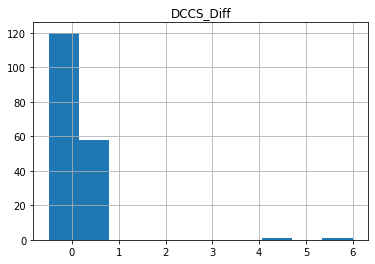

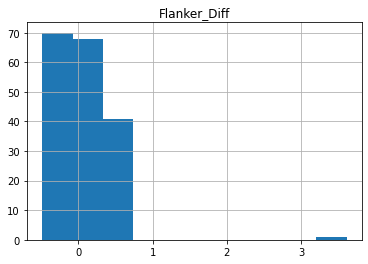

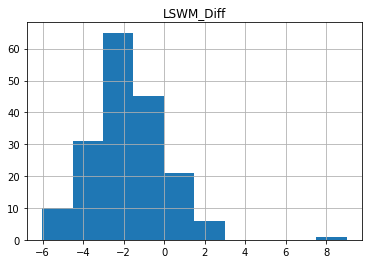

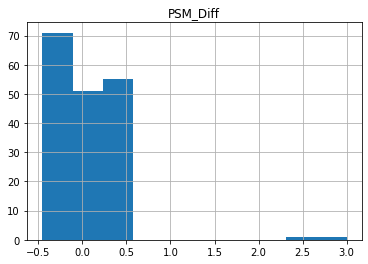

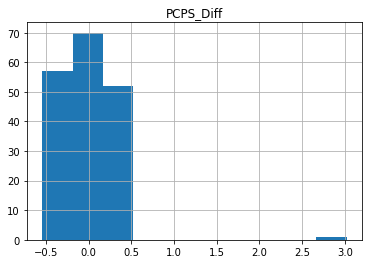

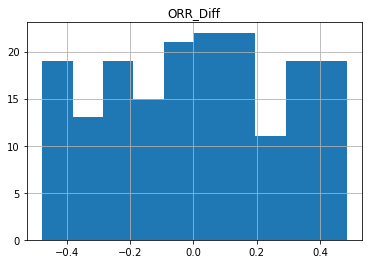

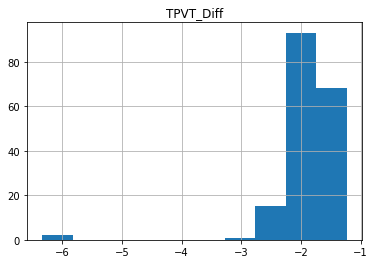

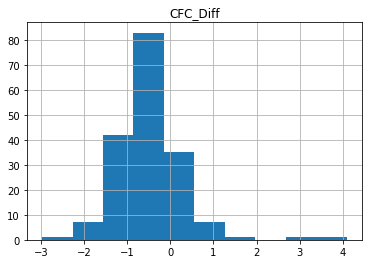

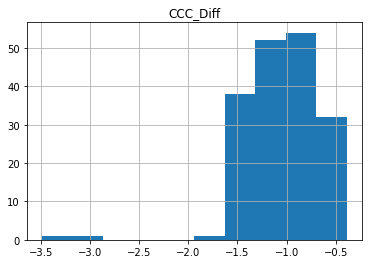

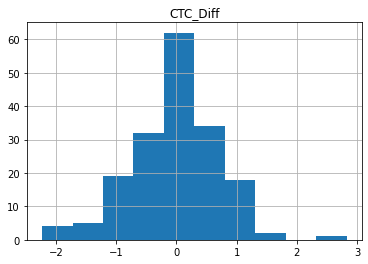

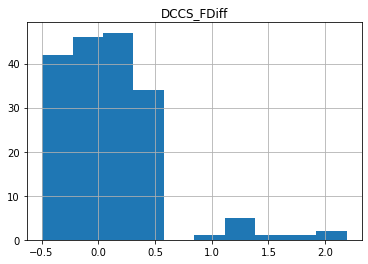

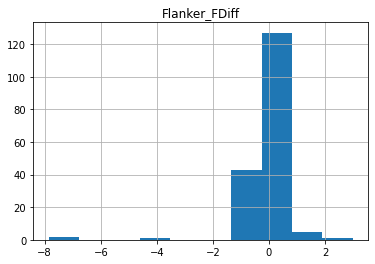

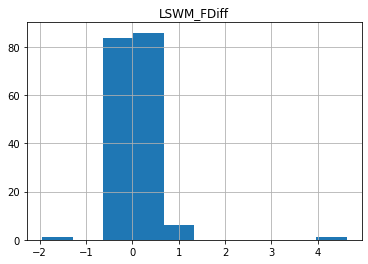

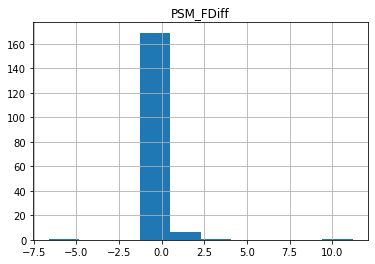

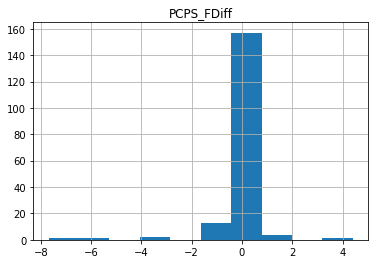

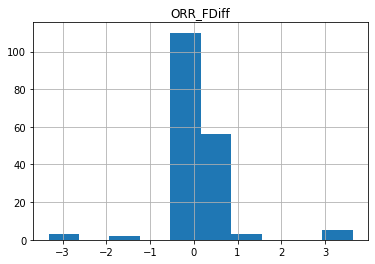

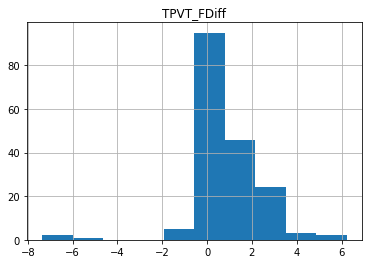

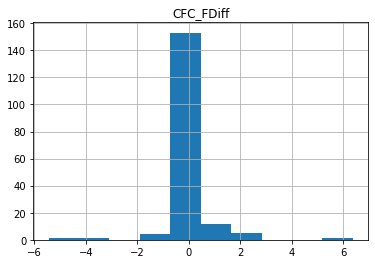

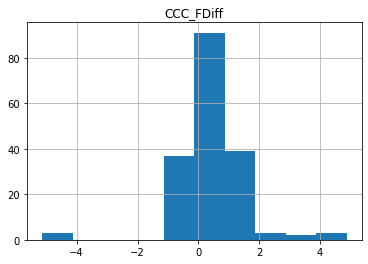

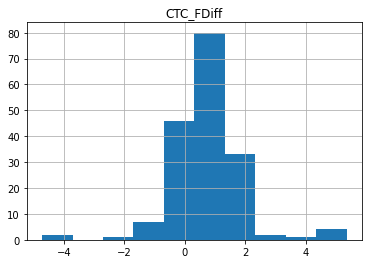

In [385]:
for diff in cd:
    genpop.hist(column=diff)

In [386]:
# calculate the Cohen's d between two samples
from numpy.random import randn
from numpy.random import seed
from numpy import mean
from numpy import var
from math import sqrt
 
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s


In [387]:
#Formula from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5133225/

def CI95(d1, d2, cohend):
    
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    
    ss = (n1+n2)/(n1*n2) + (cohend)*(cohend)/(2*n1+2*n2)
    s = sqrt(ss)
    ci1  = round((cohend-1.96*s),2)
    ci2  = round((cohend+1.96*s),2)
    
    CI = '['+str(ci1) + ', ' + str(ci2)+']'
    return CI
    

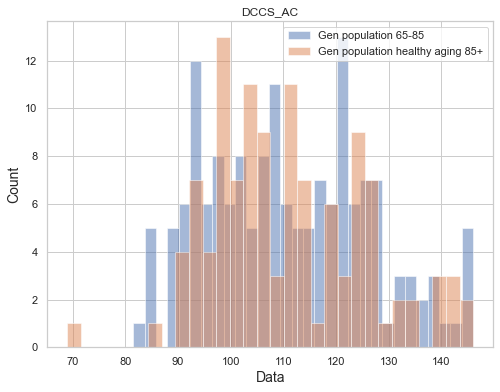

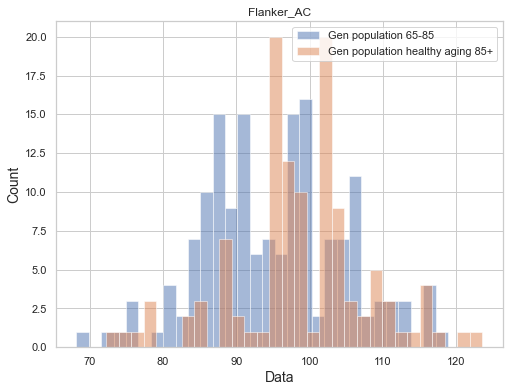

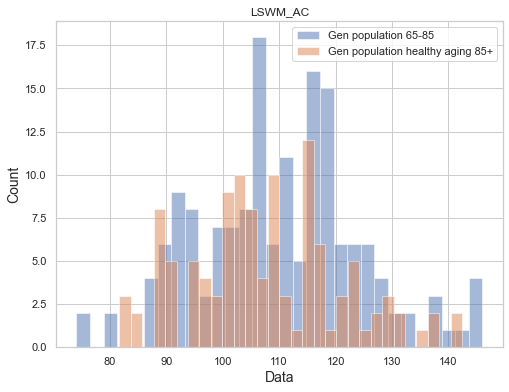

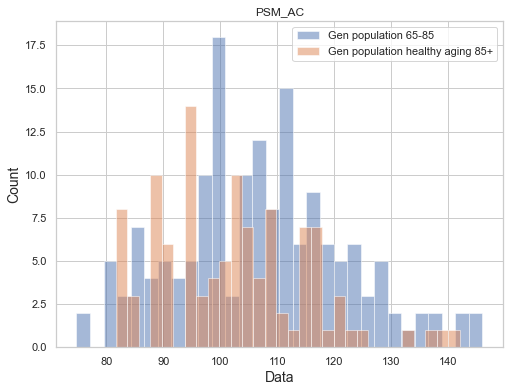

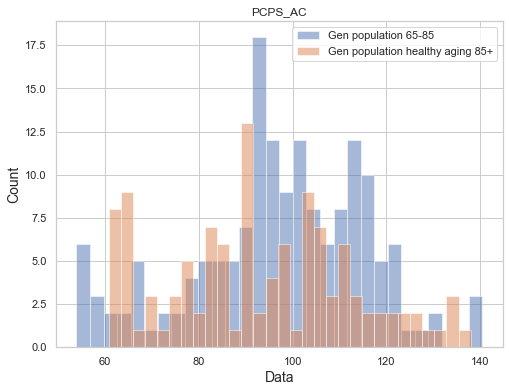

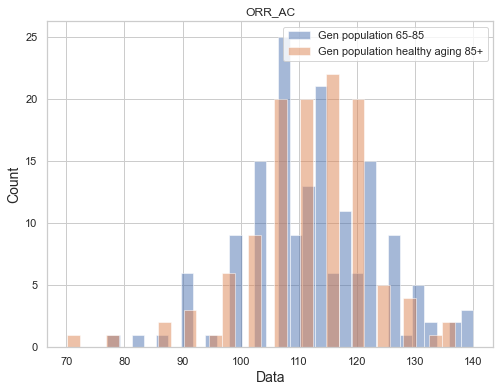

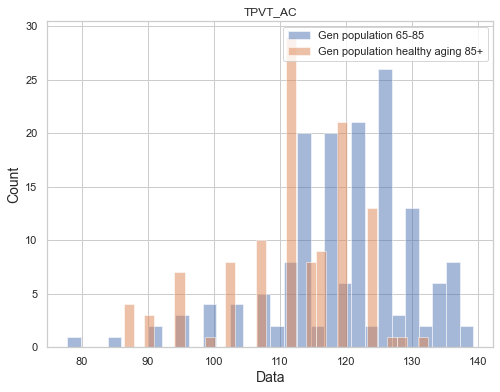

In [388]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

for col in measures:
    AC = col+'_AC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85']
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+']
    plt.figure(figsize=(8,6))
    plt.hist(g1[AC], bins=30, alpha=0.5, label='Gen population 65-85')
    plt.hist(g2[AC], bins=30, alpha=0.5, label= 'Gen population healthy aging 85+')
    plt.xlabel('Data', size=14)
    plt.ylabel('Count', size=14)
    plt.title(AC)
    plt.legend(loc='upper right')

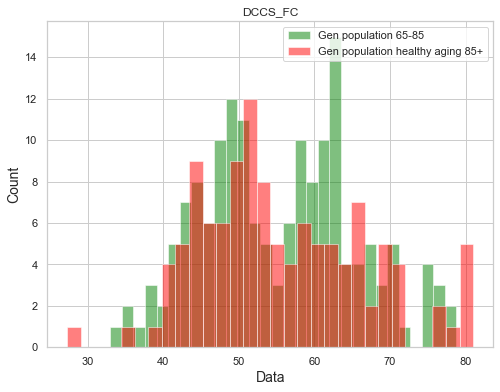

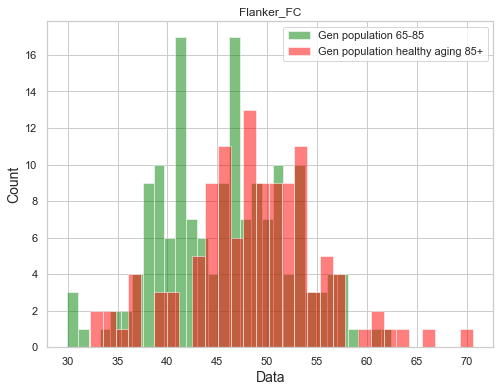

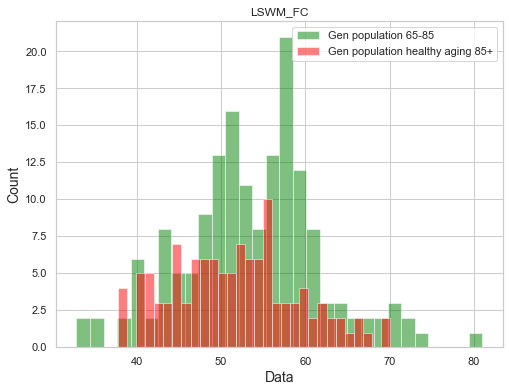

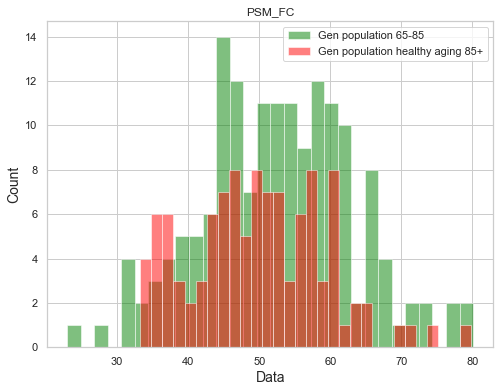

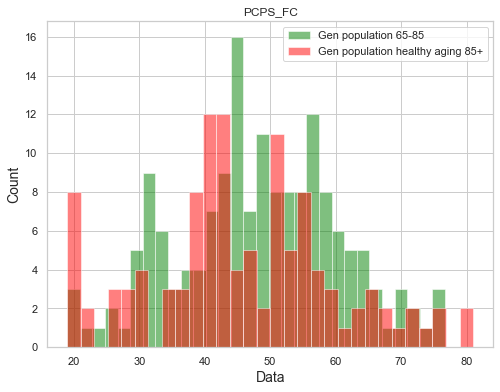

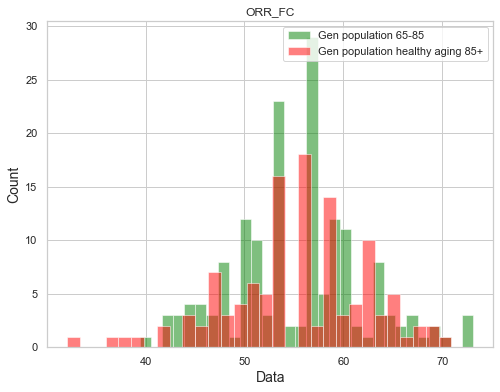

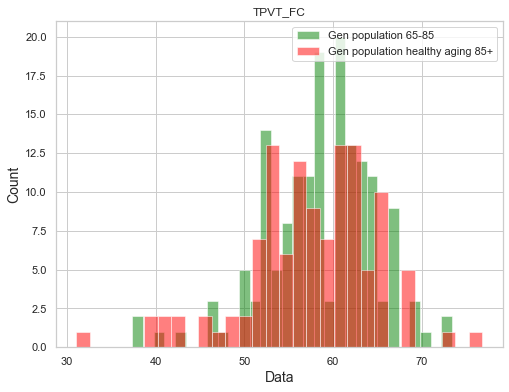

In [389]:
for col in measures:
    FC = col+'_FC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85']
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+']
    plt.figure(figsize=(8,6))
    plt.hist(g1[FC], bins=30, alpha=0.5, label='Gen population 65-85' , color='green')
    plt.hist(g2[FC], bins=30, alpha=0.5, label= 'Gen population healthy aging 85+', color='red')
    plt.xlabel('Data', size=14)
    plt.ylabel('Count', size=14)
    plt.title(FC)
    plt.legend(loc='upper right')

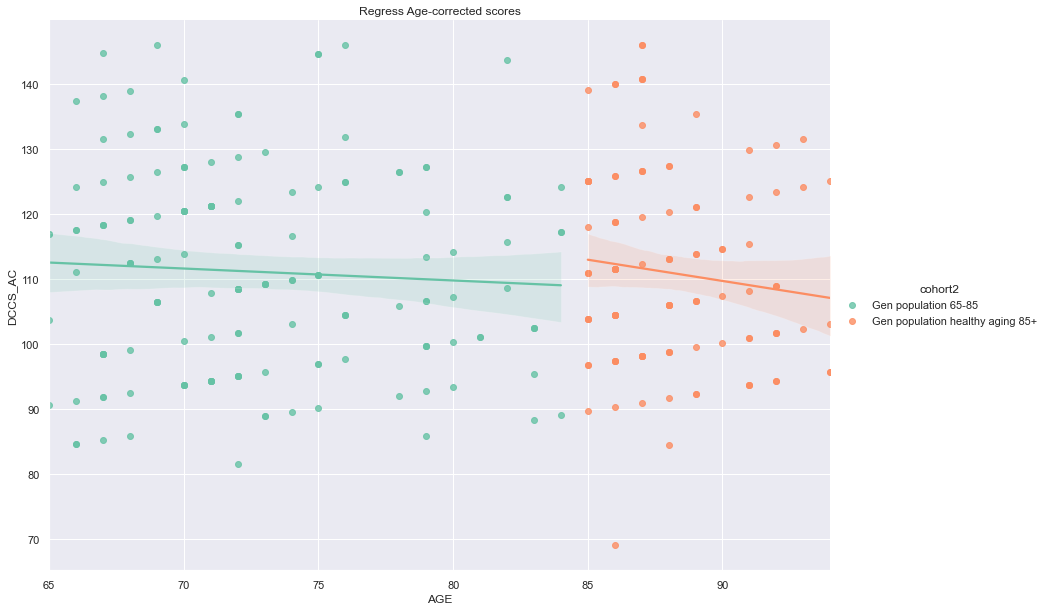

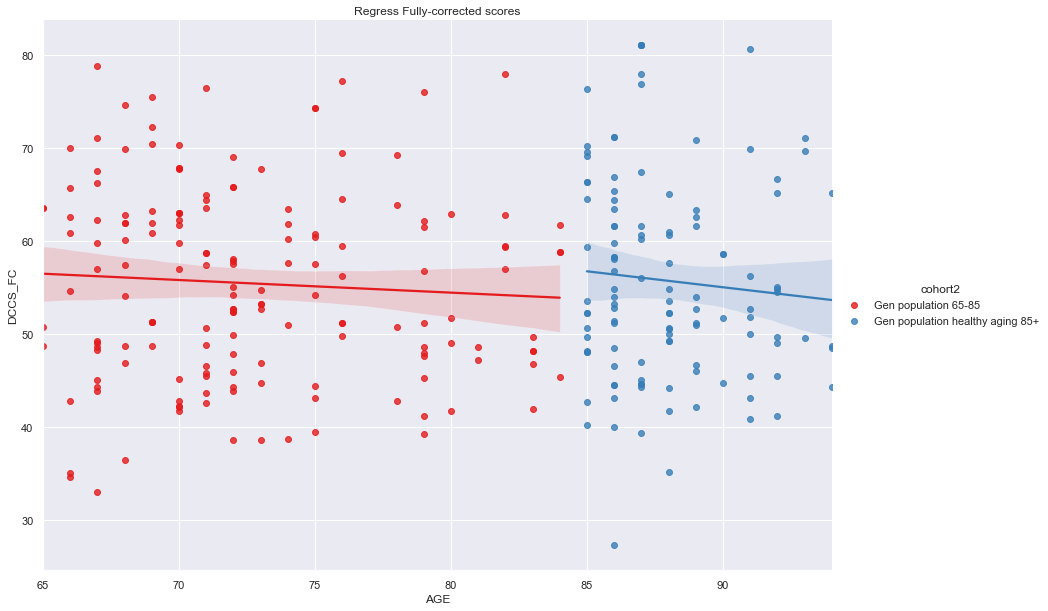

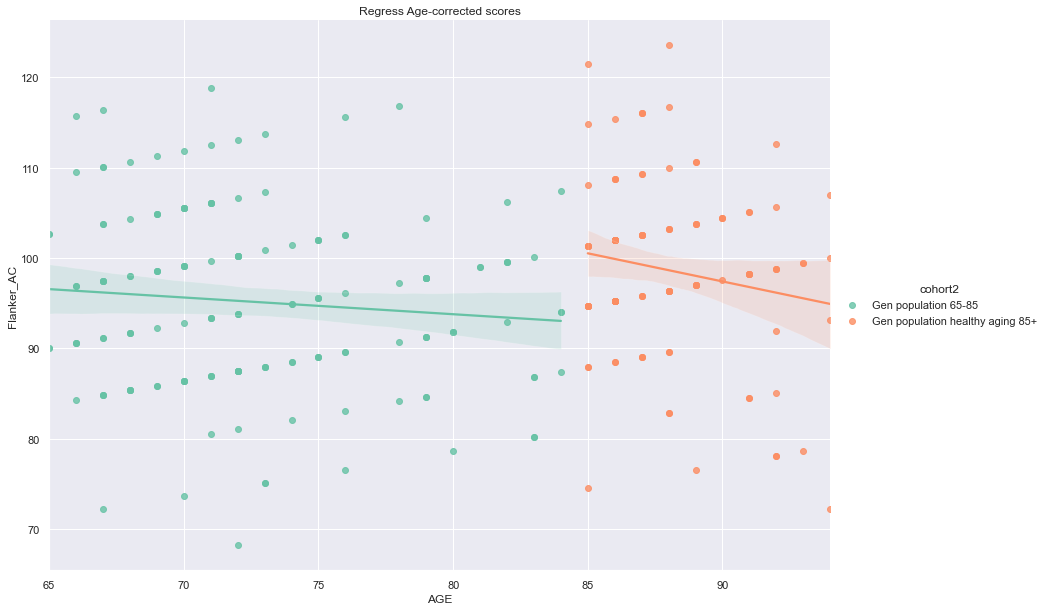

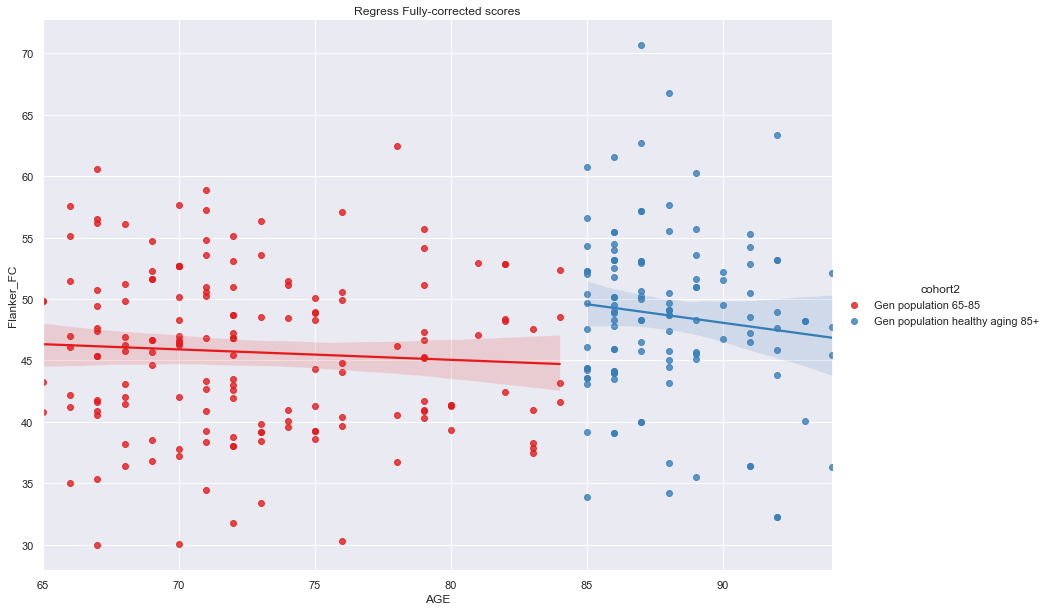

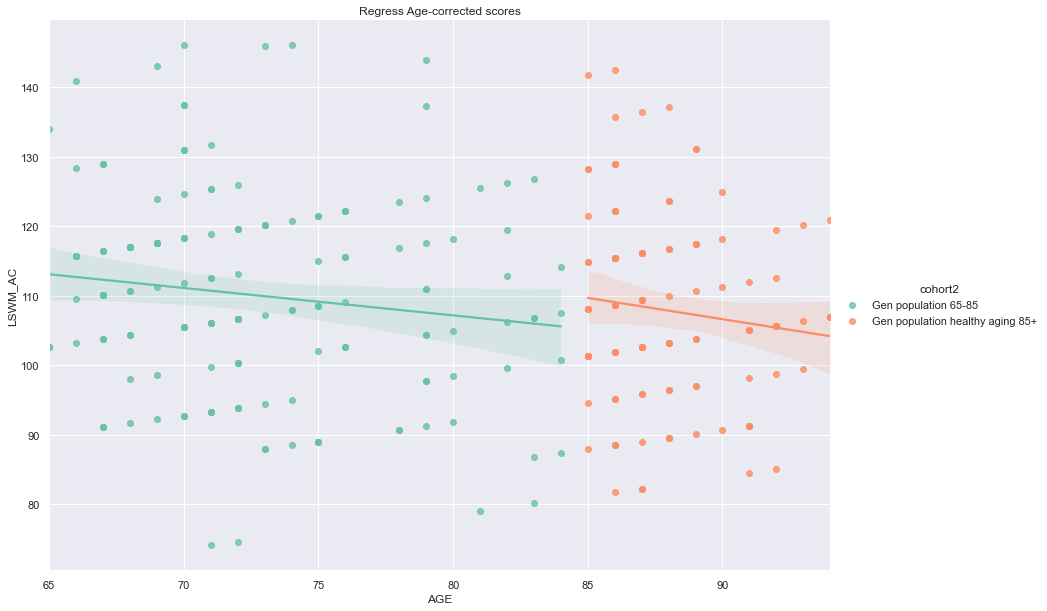

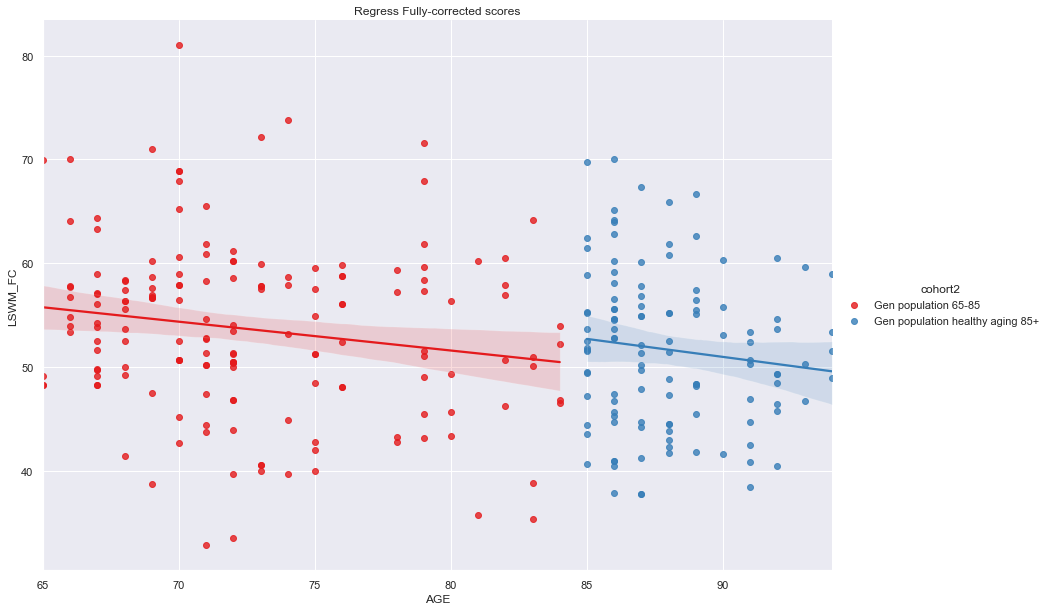

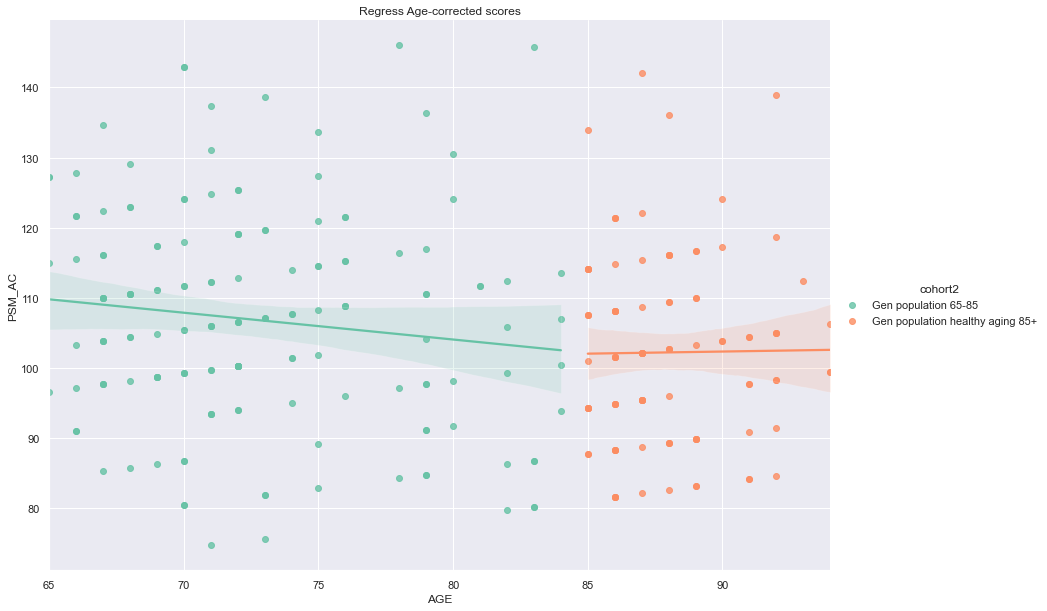

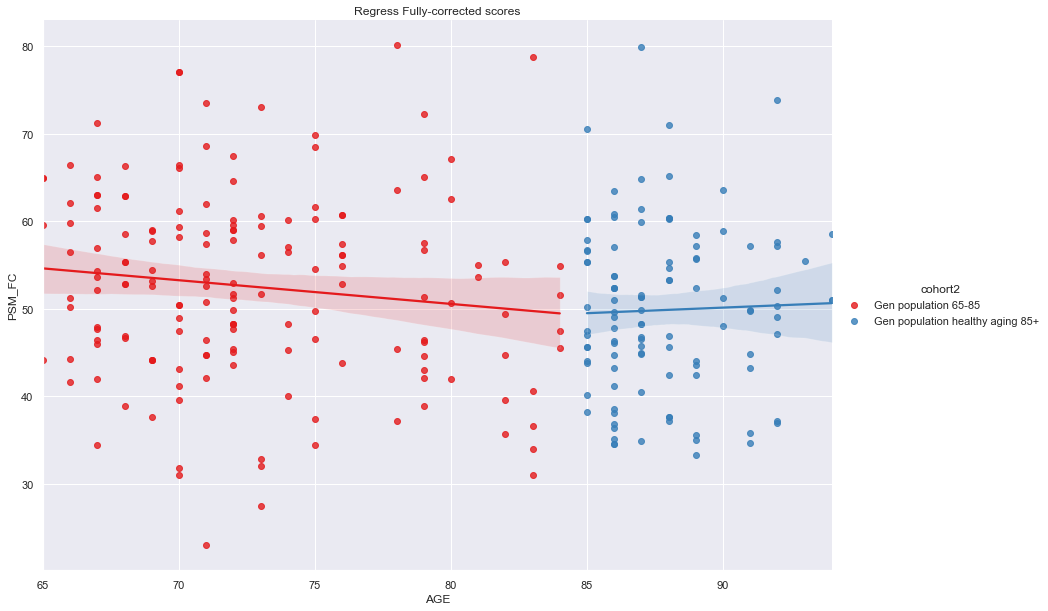

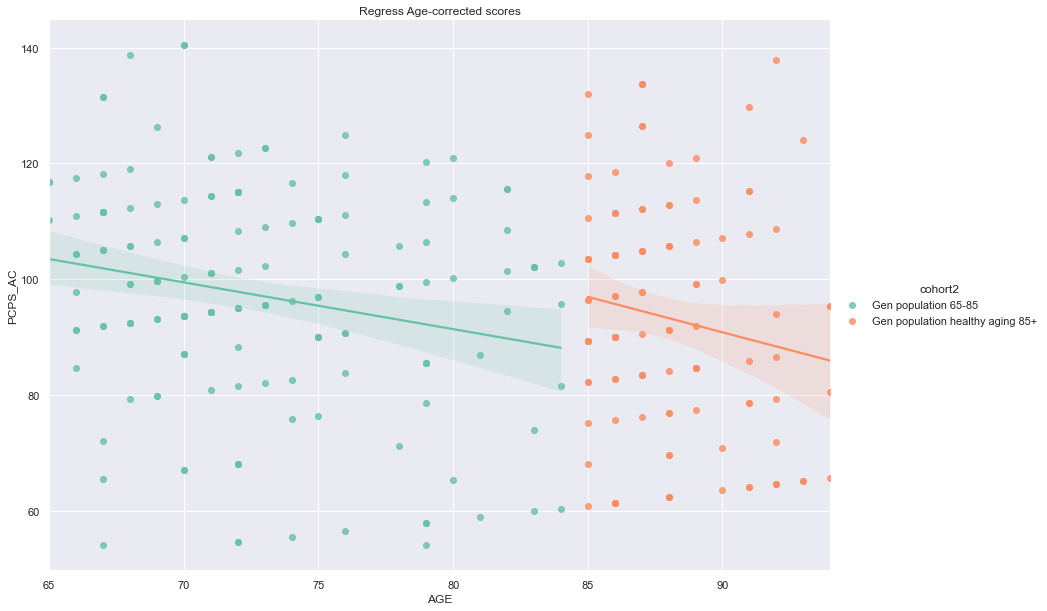

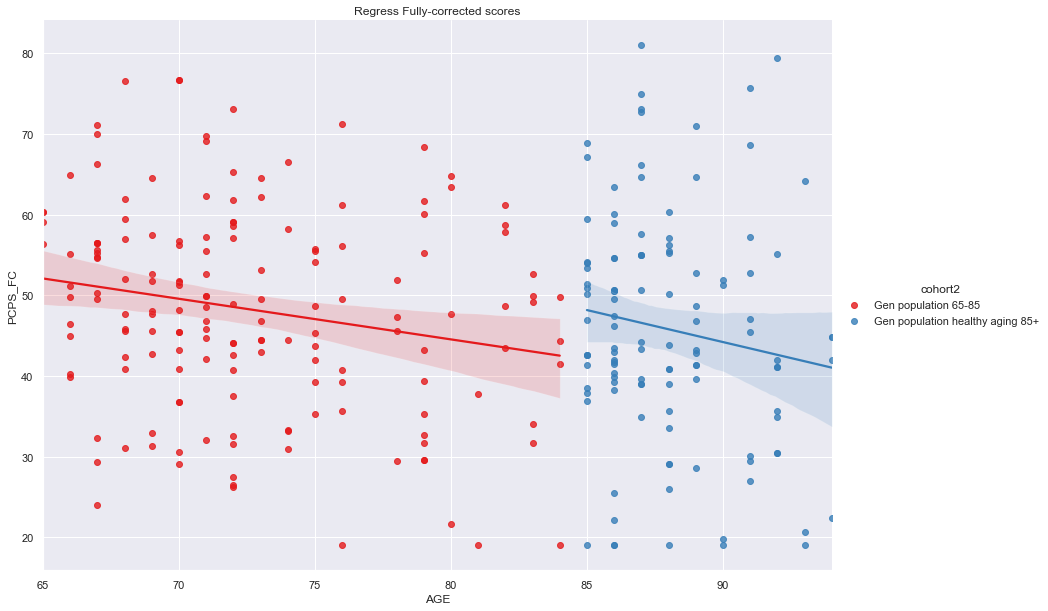

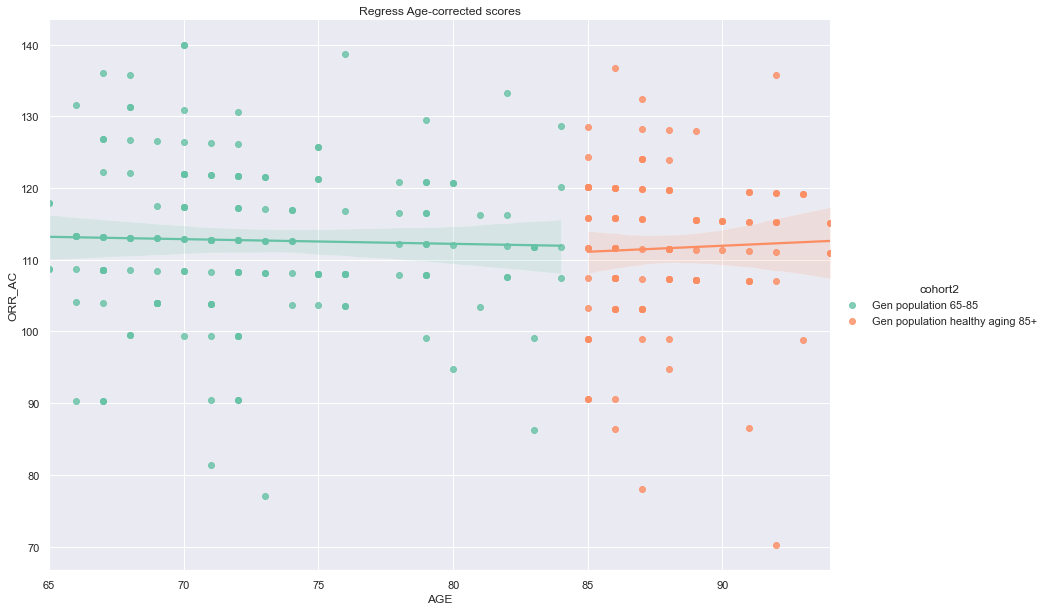

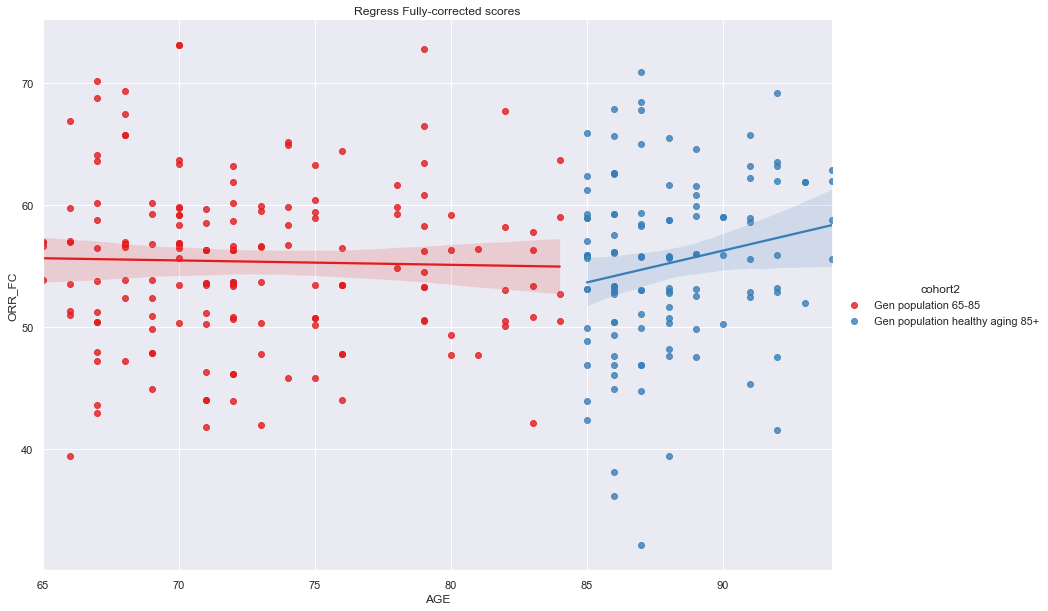

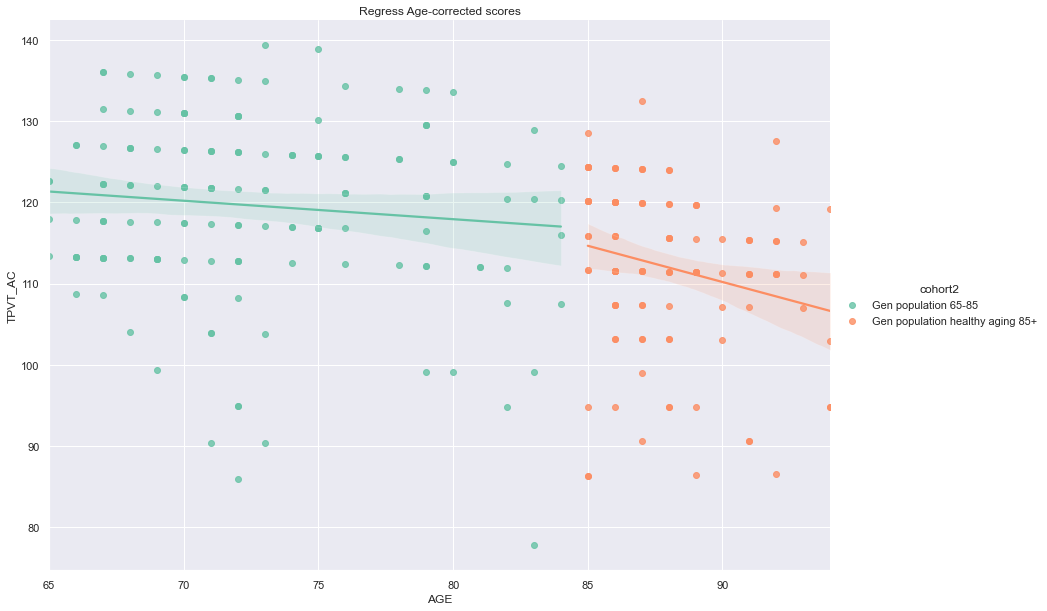

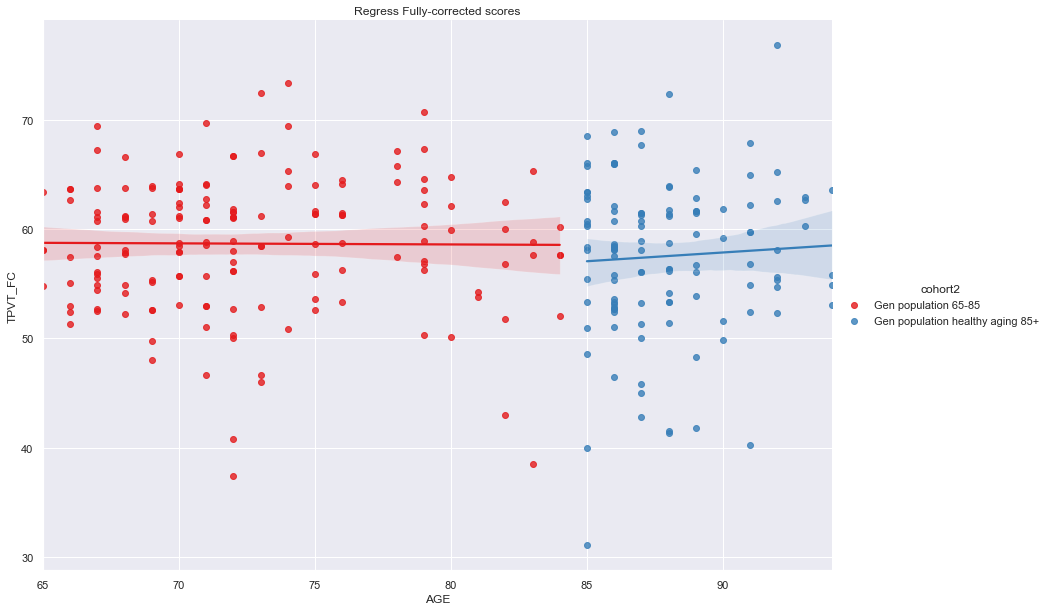

In [390]:
sns.set(style="darkgrid")
for col in measures:

    AC = col+'_AC'
    g = sns.lmplot(x="AGE", y=AC,hue="cohort2", data=genpop, palette="Set2",height=8.27, aspect=11.7/8.27)
    plt.title('Regress Age-corrected scores')

    FC = col+'_FC'
    g = sns.lmplot(x="AGE", y=FC,hue="cohort2", data=genpop, palette="Set1",height=8.27, aspect=11.7/8.27)
    plt.title('Regress Fully-corrected scores')

In [391]:
import numpy as np
import scipy.stats as stats
print("Aged-corrected")
for col in measures:
    AC = col+'_AC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85'][AC]
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+'][AC]
    print(col, 't-stat = %6.2f, pvalue = %6.2f' % stats.ttest_ind(g1.dropna(), g2.dropna(), equal_var=False))
    d = cohend(g1, g2)
    print('Cohens d: %.3f (' % d,'Gen population 65-85 vs Gen population healthy aging 85+', ")")

Aged-corrected
DCCS t-stat =   0.05, pvalue =   0.96
Cohens d: 0.007 ( Gen population 65-85 vs Gen population healthy aging 85+ )
Flanker t-stat =  -3.04, pvalue =   0.00
Cohens d: -0.368 ( Gen population 65-85 vs Gen population healthy aging 85+ )
LSWM t-stat =   1.30, pvalue =   0.19
Cohens d: 0.157 ( Gen population 65-85 vs Gen population healthy aging 85+ )
PSM t-stat =   2.70, pvalue =   0.01
Cohens d: 0.326 ( Gen population 65-85 vs Gen population healthy aging 85+ )
PCPS t-stat =   1.69, pvalue =   0.09
Cohens d: 0.208 ( Gen population 65-85 vs Gen population healthy aging 85+ )
ORR t-stat =   0.83, pvalue =   0.41
Cohens d: 0.100 ( Gen population 65-85 vs Gen population healthy aging 85+ )
TPVT t-stat =   6.01, pvalue =   0.00
Cohens d: 0.722 ( Gen population 65-85 vs Gen population healthy aging 85+ )


Small Effect Size: d=0.20
Medium Effect Size: d=0.50
Large Effect Size: d=0.80

In [392]:
print("Fully-corrected")
for col in measures:
    FC = col+'_FC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85'][FC]
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+'][FC]
    print(col, 't-stat = %6.2f, pvalue = %6.2f' % stats.ttest_ind(g1.dropna(), g2.dropna(), equal_var=False))
    # calculate cohen's d
    d = cohend(g1, g2)
    print('Cohens d: %.3f (' % d,'Gen population 65-85 vs Gen population healthy aging 85+', ")")
    print('')

Fully-corrected
DCCS t-stat =  -0.22, pvalue =   0.83
Cohens d: -0.026 ( Gen population 65-85 vs Gen population healthy aging 85+ )

Flanker t-stat =  -3.69, pvalue =   0.00
Cohens d: -0.452 ( Gen population 65-85 vs Gen population healthy aging 85+ )

LSWM t-stat =   2.05, pvalue =   0.04
Cohens d: 0.246 ( Gen population 65-85 vs Gen population healthy aging 85+ )

PSM t-stat =   2.16, pvalue =   0.03
Cohens d: 0.262 ( Gen population 65-85 vs Gen population healthy aging 85+ )

PCPS t-stat =   1.47, pvalue =   0.14
Cohens d: 0.183 ( Gen population 65-85 vs Gen population healthy aging 85+ )

ORR t-stat =   0.18, pvalue =   0.86
Cohens d: 0.022 ( Gen population 65-85 vs Gen population healthy aging 85+ )

TPVT t-stat =   1.37, pvalue =   0.17
Cohens d: 0.172 ( Gen population 65-85 vs Gen population healthy aging 85+ )



In [393]:
genpop[select].round(2).to_csv('C:/Users/tsb7592/Downloads/age_corrected_data.csv', index=False)

In [394]:
genpop[genpop.AGE <= 85][['AGE','MALE','EDUCATION']].describe()

,AGE,MALE,EDUCATION
count,180.00,180.00,180.00
mean,73.92,0.35,16.94
std,6.07,0.48,2.14
min,65.00,0.00,8.00
25%,69.00,0.00,16.00
50%,72.00,0.00,18.00
75%,79.00,1.00,18.00
max,85.00,1.00,20.00


In [395]:
genpop[genpop.AGE<= 85]['MARISTAT'].value_counts()

Married                                      56
Divorced                                     24
Widowed                                      21
Never married (or marriage was annulled)      3
Living as married/domestic partner            2
Name: MARISTAT, dtype: int64

In [396]:
# for the below 85 group and above 85 group: age (mean and sd), education level, race/ethnicity, gender, marital status

genpop[genpop.AGE > 85][['AGE','MALE','EDUCATION']].describe()

,AGE,MALE,EDUCATION
count,100.00,100.00,100.00
mean,88.55,0.48,16.42
std,2.40,0.50,2.94
min,86.00,0.00,7.00
25%,86.00,0.00,15.50
50%,88.00,0.00,16.00
75%,91.00,1.00,18.00
max,94.00,1.00,20.00


In [397]:
genpop[genpop.AGE> 85]['MARISTAT'].value_counts()

Married                                      20
Widowed                                      15
Divorced                                      5
Never married (or marriage was annulled)      5
Name: MARISTAT, dtype: int64

In [398]:
genpop.columns

Index(['index', 'ptid', 'assmnt', 'site', 'cohort2', 'LANGUAGE', 'AGE',
       'gender_rc', 'ethnicity_rc', 'race_tb_rc',
       ...
       'ORR_AC', 'ORR_Diff', 'TPVT_AC', 'TPVT_Diff', 'CFC_AC', 'CFC_Diff',
       'CCC_AC', 'CCC_Diff', 'CTC_AC', 'CTC_Diff'],
      dtype='object', length=249)

In [399]:
genpop[genpop.AGE> 85]['race'].value_counts()

White                        91
Black or African American     8
Asian                         1
Name: race, dtype: int64

In [400]:
genpop.EDUCATION.describe()

count   280.00
mean     16.76
std       2.46
min       7.00
25%      16.00
50%      18.00
75%      18.00
max      20.00
Name: EDUCATION, dtype: float64

In [401]:
table = pd.DataFrame(columns=('<85', '>=85'))

for col in genpop.columns:
    if 'UCS' in col:
        avg = round(genpop[genpop.AGE< 85][col].mean(), 2)
        st = round(genpop[genpop.AGE<85][col].std(), 2)
        val = str(avg) + '('+str(st)+')'
        avg1 = round(genpop[genpop.AGE>= 85][col].mean(), 2)
        st1 = round(genpop[genpop.AGE>=85][col].std(), 2)
        val1 = str(avg1) + '('+str(st1)+')'
        ind = col.split('_')[0]
        table.loc[ind] = [val, val1]

In [402]:
table

,<85,>=85
CCC,116.88(7.18),114.11(6.84)
CFC,92.77(10.21),82.57(9.67)
CTC,105.11(8.36),97.92(7.68)
DCCS,100.27(7.81),93.38(11.05)
Flanker,93.31(7.42),89.87(8.45)
LSWM,98.54(10.65),90.56(10.24)
ORR,111.88(5.48),111.94(6.02)
PCPS,86.98(14.22),77.24(13.51)
PSM,99.43(13.24),88.41(9.57)
TPVT,120.42(9.04),115.28(8.31)


In [403]:
ACcol= ['DCCS_AC',
 'Flanker_AC',
 'LSWM_AC',
 'PSM_AC',
 'PCPS_AC',
 'ORR_AC',
 'TPVT_AC',
 'CFC_AC',
 'CCC_AC',
 'CTC_AC']

In [404]:
table1 = pd.DataFrame(columns=('<85_AC', '>=85_AC'))

for col in ACcol:
    avg = round(genpop[genpop.AGE< 85][col].mean(), 2)
    st = round(genpop[genpop.AGE<85][col].std(), 2)
    val = str(avg) + '('+str(st)+')'
    avg1 = round(genpop[genpop.AGE>= 85][col].mean(), 2)
    st1 = round(genpop[genpop.AGE>=85][col].std(), 2)
    val1 = str(avg1) + '('+str(st1)+')'
    ind = col.split('_')[0]
    table1.loc[ind] = [val, val1]

In [405]:
table1

,<85_AC,>=85_AC
DCCS,111.12(15.39),111.02(14.63)
Flanker,95.13(9.73),98.66(9.41)
LSWM,110.05(14.46),107.85(13.55)
PSM,106.86(15.03),102.22(13.0)
PCPS,97.26(18.66),93.26(19.92)
ORR,112.71(10.94),111.62(10.55)
TPVT,119.59(10.83),112.02(9.99)
CFC,105.85(14.23),104.55(13.67)
CCC,117.56(11.07),112.69(10.01)
CTC,112.68(11.29),109.83(10.2)


In [406]:
FCcol =['DCCS_FC',
'Flanker_FC',
'LSWM_FC',
'PSM_FC',
'PCPS_FC',
'ORR_FC',
'TPVT_FC',
'CFC_FC',
'CCC_FC',
'CTC_FC']

In [407]:
table2 = pd.DataFrame(columns=('<85_FC', '>=85_FC'))

for col in FCcol:
    avg = round(genpop[genpop.AGE< 85][col].mean(), 2)
    st = round(genpop[genpop.AGE<85][col].std(), 2)
    val = str(avg) + '('+str(st)+')'
    avg1 = round(genpop[genpop.AGE>= 85][col].mean(), 2)
    st1 = round(genpop[genpop.AGE>=85][col].std(), 2)
    val1 = str(avg1) + '('+str(st1)+')'
    ind = col.split('_')[0]
    table2.loc[ind] = [val, val1]

In [408]:
table2

,<85_FC,>=85_FC
DCCS,55.42(10.23),55.7(10.96)
Flanker,45.67(6.5),48.68(6.82)
LSWM,53.62(8.26),51.67(7.5)
PSM,52.52(10.75),49.85(9.42)
PCPS,48.21(12.52),45.79(14.22)
ORR,55.36(6.64),55.21(7.17)
TPVT,58.67(6.09),57.53(7.27)
CFC,51.46(9.05),50.86(9.6)
CCC,57.71(6.25),56.97(7.01)
CTC,55.03(6.36),54.61(7.16)


In [409]:
af = pd.merge(table1, table2, left_index=True, right_index=True)

In [410]:
rv = pd.merge(table, af, left_index=True, right_index=True)
rv

,<85,>=85,<85_AC,>=85_AC,<85_FC,>=85_FC
CCC,116.88(7.18),114.11(6.84),117.56(11.07),112.69(10.01),57.71(6.25),56.97(7.01)
CFC,92.77(10.21),82.57(9.67),105.85(14.23),104.55(13.67),51.46(9.05),50.86(9.6)
CTC,105.11(8.36),97.92(7.68),112.68(11.29),109.83(10.2),55.03(6.36),54.61(7.16)
DCCS,100.27(7.81),93.38(11.05),111.12(15.39),111.02(14.63),55.42(10.23),55.7(10.96)
Flanker,93.31(7.42),89.87(8.45),95.13(9.73),98.66(9.41),45.67(6.5),48.68(6.82)
LSWM,98.54(10.65),90.56(10.24),110.05(14.46),107.85(13.55),53.62(8.26),51.67(7.5)
ORR,111.88(5.48),111.94(6.02),112.71(10.94),111.62(10.55),55.36(6.64),55.21(7.17)
PCPS,86.98(14.22),77.24(13.51),97.26(18.66),93.26(19.92),48.21(12.52),45.79(14.22)
PSM,99.43(13.24),88.41(9.57),106.86(15.03),102.22(13.0),52.52(10.75),49.85(9.42)
TPVT,120.42(9.04),115.28(8.31),119.59(10.83),112.02(9.99),58.67(6.09),57.53(7.27)


In [411]:
rv.to_csv('C:/Users/tsb7592/Downloads/Table_2.csv')

In [412]:
abs(genpop['LSWM_FDiff']).value_counts(bins=[0, 0.01, 0.02,100])

(0.02, 100.0]     173
(0.01, 0.02]        3
(-0.001, 0.01]      2
Name: LSWM_FDiff, dtype: int64

In [413]:
data =genpop[genpop['LSWM_FDiff'].notnull()]['LSWM_FDiff']
data

0     -0.48
1      0.32
7      0.26
8     -0.35
9     -0.38
       ... 
824    0.22
825   -0.38
829   -0.03
834    0.13
836   -0.30
Name: LSWM_FDiff, Length: 178, dtype: float64

In [414]:
data.abs().value_counts(bins=[0, 0.01, 0.02,100], normalize=True)

(0.02, 100.0]    0.97
(0.01, 0.02]     0.02
(-0.001, 0.01]   0.01
Name: LSWM_FDiff, dtype: float64

In [415]:
genpop['CTC_FDiff'].value_counts(bins=[-100,-0.02,-0.01, 0.01, 0.02,100])

(0.02, 100.0]        139
(-100.001, -0.02]     35
(-0.01, 0.01]          1
(0.01, 0.02]           1
(-0.02, -0.01]         0
Name: CTC_FDiff, dtype: int64

In [416]:
N =[]
avg = []
for diff in cd:
    data = genpop[genpop[diff].notnull()][diff]
    N.append(data.shape[0])
    avg.append(round(data.mean(),2))
    row = data.abs().value_counts(bins=[0, 1, 2,100], normalize=True).to_frame()
    display(row)
    if diff !='DCCS_Diff':
        dat =dat.join(row)
    else:
        dat= row
        
dat.loc['Average Diff'] = avg
dat.loc['N'] = N

,DCCS_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,Flanker_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,LSWM_Diff
"(2.0, 100.0]",0.52
"(-0.001, 1.0]",0.27
"(1.0, 2.0]",0.21


,PSM_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,PCPS_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,ORR_Diff
"(-0.001, 1.0]",1.00
"(1.0, 2.0]",0.00
"(2.0, 100.0]",0.00


,TPVT_Diff
"(1.0, 2.0]",0.70
"(2.0, 100.0]",0.30
"(-0.001, 1.0]",0.00


,CFC_Diff
"(-0.001, 1.0]",0.74
"(1.0, 2.0]",0.24
"(2.0, 100.0]",0.02


,CCC_Diff
"(1.0, 2.0]",0.51
"(-0.001, 1.0]",0.48
"(2.0, 100.0]",0.01


,CTC_Diff
"(-0.001, 1.0]",0.86
"(1.0, 2.0]",0.11
"(2.0, 100.0]",0.02


,DCCS_FDiff
"(-0.001, 1.0]",0.94
"(1.0, 2.0]",0.05
"(2.0, 100.0]",0.01


,Flanker_FDiff
"(-0.001, 1.0]",0.96
"(1.0, 2.0]",0.02
"(2.0, 100.0]",0.02


,LSWM_FDiff
"(-0.001, 1.0]",0.97
"(1.0, 2.0]",0.02
"(2.0, 100.0]",0.01


,PSM_FDiff
"(-0.001, 1.0]",0.95
"(1.0, 2.0]",0.03
"(2.0, 100.0]",0.02


,PCPS_FDiff
"(-0.001, 1.0]",0.97
"(2.0, 100.0]",0.03
"(1.0, 2.0]",0.01


,ORR_FDiff
"(-0.001, 1.0]",0.93
"(2.0, 100.0]",0.04
"(1.0, 2.0]",0.02


,TPVT_FDiff
"(-0.001, 1.0]",0.57
"(1.0, 2.0]",0.25
"(2.0, 100.0]",0.19


,CFC_FDiff
"(-0.001, 1.0]",0.94
"(1.0, 2.0]",0.03
"(2.0, 100.0]",0.03


,CCC_FDiff
"(-0.001, 1.0]",0.75
"(1.0, 2.0]",0.20
"(2.0, 100.0]",0.06


,CTC_FDiff
"(-0.001, 1.0]",0.65
"(1.0, 2.0]",0.27
"(2.0, 100.0]",0.07


In [417]:
dat.head()

,DCCS_Diff,Flanker_Diff,LSWM_Diff,PSM_Diff,PCPS_Diff,ORR_Diff,TPVT_Diff,CFC_Diff,CCC_Diff,CTC_Diff,DCCS_FDiff,Flanker_FDiff,LSWM_FDiff,PSM_FDiff,PCPS_FDiff,ORR_FDiff,TPVT_FDiff,CFC_FDiff,CCC_FDiff,CTC_FDiff
"(-0.001, 1.0]",0.99,0.99,0.27,0.99,0.99,1.00,0.00,0.74,0.48,0.86,0.94,0.96,0.97,0.95,0.97,0.93,0.57,0.94,0.75,0.65
"(2.0, 100.0]",0.01,0.01,0.52,0.01,0.01,0.00,0.30,0.02,0.01,0.02,0.01,0.02,0.01,0.02,0.03,0.04,0.19,0.03,0.06,0.07
"(1.0, 2.0]",0.00,0.00,0.21,0.00,0.00,0.00,0.70,0.24,0.51,0.11,0.05,0.02,0.02,0.03,0.01,0.02,0.25,0.03,0.20,0.27
Average Diff,0.02,0.05,-1.72,0.06,0.01,0.01,-1.88,-0.51,-1.04,-0.03,0.10,-0.07,0.06,0.10,-0.04,0.03,0.73,0.05,0.43,0.69
N,180.00,180.00,179.00,179.00,180.00,180.00,179.00,178.00,179.00,177.00,179.00,179.00,178.00,178.00,179.00,179.00,178.00,177.00,178.00,176.00


In [418]:
dat.index = ['+/- 1', 'above 2', '1-2 points','Average Diff', 'N']

In [419]:
dat

,DCCS_Diff,Flanker_Diff,LSWM_Diff,PSM_Diff,PCPS_Diff,ORR_Diff,TPVT_Diff,CFC_Diff,CCC_Diff,CTC_Diff,DCCS_FDiff,Flanker_FDiff,LSWM_FDiff,PSM_FDiff,PCPS_FDiff,ORR_FDiff,TPVT_FDiff,CFC_FDiff,CCC_FDiff,CTC_FDiff
+/- 1,0.99,0.99,0.27,0.99,0.99,1.00,0.00,0.74,0.48,0.86,0.94,0.96,0.97,0.95,0.97,0.93,0.57,0.94,0.75,0.65
above 2,0.01,0.01,0.52,0.01,0.01,0.00,0.30,0.02,0.01,0.02,0.01,0.02,0.01,0.02,0.03,0.04,0.19,0.03,0.06,0.07
1-2 points,0.00,0.00,0.21,0.00,0.00,0.00,0.70,0.24,0.51,0.11,0.05,0.02,0.02,0.03,0.01,0.02,0.25,0.03,0.20,0.27
Average Diff,0.02,0.05,-1.72,0.06,0.01,0.01,-1.88,-0.51,-1.04,-0.03,0.10,-0.07,0.06,0.10,-0.04,0.03,0.73,0.05,0.43,0.69
N,180.00,180.00,179.00,179.00,180.00,180.00,179.00,178.00,179.00,177.00,179.00,179.00,178.00,178.00,179.00,179.00,178.00,177.00,178.00,176.00


In [420]:
dat.to_csv('C:/Users/tsb7592/Downloads/Table_diff.csv')

# t test, mean differences, 95 CI

In [421]:
def get_list(li, element):
    list_of_numbers = []
    list_of_numbers.append(element)
    for tup in li:
        try:
            list_of_numbers.append(round(float(tup),2))
        except ValueError:
            pass
        
    del list_of_numbers[2]
    
    CI = '['+str(list_of_numbers[2]) + ', ' + str(list_of_numbers[3])+']'
    list_of_numbers = list_of_numbers[:2]
    list_of_numbers.append(CI)
    list_of_numbers.append(li[-1])
    
    
    return list_of_numbers

In [422]:
genpop[genpop.AGE<85].shape

(162, 249)

In [423]:
l1= genpop[genpop.cohort2=='Gen population 65-85']['DCCS_UCSScore'].dropna()
l2= genpop[genpop.cohort2=='Gen population healthy aging 85+']['DCCS_UCSScore'].dropna()

In [424]:
len(g1)

162

In [425]:
genpop.shape

(280, 249)

In [426]:
def tukey_test(df, var):
    df =df[['cohort', var]].dropna()
    tukey = pairwise_tukeyhsd(endog=df[var],
                          groups=df['cohort'],
                          alpha=0.05)

    return(tukey)

In [427]:
gg1 = genpop[genpop.cohort2=='Gen population 65-85']['DCCS_UCSScore'].dropna()

In [428]:
gg2 = genpop[genpop.cohort2!='Gen population 65-85']['DCCS_UCSScore'].dropna()
gg2

2     102.00
4      97.00
6      66.00
16     90.00
25     66.00
       ...  
663    99.00
664   108.00
757   103.00
770    95.00
823    91.00
Name: DCCS_UCSScore, Length: 117, dtype: float64

In [429]:
tstat, p = stats.ttest_ind(X1, X2)

NameError: name 'X1' is not defined

In [430]:
def number(X1, X2):
    
    tstat, p = stats.ttest_ind(X1, X2)
    diff = X1.mean()-X2.mean()
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    a,b=cm.tconfint_diff(usevar='unequal')
    CI = '['+str(a)[:4]+', '+str(b)[:4]+']'
                 
    print('t-statistic = %6.2f pvalue = %6.2f' % stats.ttest_ind(X1, X2, equal_var = False))
    print("mean difference is %6.2f" % (X1.mean()-X2.mean()))
    print('95 CI=[%6.2f,%6.2f]' %cm.tconfint_diff(usevar='unequal'))
                 
    return round(tstat,2), round(p,2),round(diff,2), CI 

In [431]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np, statsmodels.stats.api as sms

def all_stat(data, col):
    UCS = col+'_UCSScore'
    AC = col+'_AC'
    ACSS = col+'_ACSScore'
    FC = col+'_FC'
    FCTS= col+'_FCTScore'
    
    g1 = data[data.cohort2=='Gen population 65-85'][UCS].dropna()
    g2 = data[data.cohort2=='Gen population healthy aging 85+'][UCS].dropna()

    g3 = data[data.cohort2=='Gen population 65-85'][AC].dropna()
    g4 = data[data.cohort2=='Gen population healthy aging 85+'][AC].dropna()
    g5 = data[data.cohort2=='Gen population 65-85'][ACSS].dropna()
    
    g6 = data[data.cohort2=='Gen population 65-85'][FC].dropna()
    g7 = data[data.cohort2=='Gen population healthy aging 85+'][FC].dropna()
    g8 = data[data.cohort2=='Gen population 65-85'][FCTS].dropna()
    
    
    # calculate numbers
    t1, p1, d1, c1= number(g1,g2)
    ch1 = round(cohend(g1, g2),2)
    
    t2, p2, d2, c2=number(g3, g4)
    ch2 = round(cohend(g3, g4),2)
    
    t3, p3, d3, c3 = number(g3, g5)
    ch3 = round(cohend(g3, g5),2)
    
    t4, p4, d4, c4 = number(g6, g7)
    ch4 = round(cohend(g6, g7),2)
    
    t5, p5, d5, c5 =number(g6, g8)
    ch5 = round(cohend(g6, g8),2)                                           
    coh = [[ch1,ch2,ch3,ch4,ch5],[t1,t2,t3,t4,t5],[p1,p2,p3,p4,p5],[d1, d2, d3, d4, d5], [c1,c2,c3,c4,c5]]
    
    rdf = pd.DataFrame(coh,  index =[col+" cohen's d","tstat",'p value', "mean diff", '95 CI' ],columns =['65-85 vs 85+','AC: 65-85 (derived) vs 85+ ','AC: 65-85 (given) vs 85+ ','FC: 65-85 (derived) vs 85+ ','FC: 65-85 (given) vs 85+ '], dtype = float)

    return rdf
    

In [432]:
allcol= ['DCCS',
 'Flanker',
 'LSWM',
 'PSM',
 'PCPS',
 'ORR',
 'TPVT',
 'CFC',
 'CCC',
 'CTC']

In [433]:
rv =[]
for col in allcol:
    rdf = all_stat(genpop, col)
    rv.append(rdf)
rv = pd.concat(rv)

t-statistic =   5.78 pvalue =   0.00
mean difference is   6.90
95 CI=[  4.54,  9.25]
t-statistic =   0.05 pvalue =   0.96
mean difference is   0.10
95 CI=[ -3.47,  3.67]
t-statistic =  -0.01 pvalue =   0.99
mean difference is  -0.01
95 CI=[ -3.39,  3.36]
t-statistic =  -0.22 pvalue =   0.83
mean difference is  -0.28
95 CI=[ -2.83,  2.27]
t-statistic =  -0.13 pvalue =   0.90
mean difference is  -0.15
95 CI=[ -2.38,  2.09]
t-statistic =   3.53 pvalue =   0.00
mean difference is   3.44
95 CI=[  1.52,  5.37]
t-statistic =  -3.04 pvalue =   0.00
mean difference is  -3.53
95 CI=[ -5.81, -1.24]
t-statistic =  -0.04 pvalue =   0.97
mean difference is  -0.04
95 CI=[ -2.17,  2.08]
t-statistic =  -3.69 pvalue =   0.00
mean difference is  -3.00
95 CI=[ -4.60, -1.40]
t-statistic =   0.07 pvalue =   0.94
mean difference is   0.05
95 CI=[ -1.38,  1.49]
t-statistic =   6.29 pvalue =   0.00
mean difference is   7.99
95 CI=[  5.49, 10.49]
t-statistic =   1.30 pvalue =   0.19
mean difference is   2.21
95

In [434]:
rv

,65-85 vs 85+,AC: 65-85 (derived) vs 85+,AC: 65-85 (given) vs 85+,FC: 65-85 (derived) vs 85+,FC: 65-85 (given) vs 85+
DCCS cohen's d,0.74,0.01,-0.00,-0.03,-0.01
tstat,6.11,0.05,-0.01,-0.22,-0.13
p value,0.00,0.96,0.99,0.83,0.90
mean diff,6.90,0.10,-0.01,-0.28,-0.15
95 CI,"[4.54, 9.24]","[-3.4, 3.67]","[-3.3, 3.36]","[-2.8, 2.26]","[-2.3, 2.09]"
Flanker cohen's d,0.44,-0.37,-0.00,-0.45,0.01
tstat,3.60,-3.02,-0.04,-3.72,0.07
p value,0.00,0.00,0.97,0.00,0.94
mean diff,3.44,-3.53,-0.04,-3.00,0.05
95 CI,"[1.51, 5.36]","[-5.8, -1.2]","[-2.1, 2.08]","[-4.6, -1.3]","[-1.3, 1.48]"


In [435]:
rv.to_csv('C:/Users/tsb7592/Downloads/table_stat.csv')